In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

from lonboard import Map, ScatterplotLayer
from functions import geo_to_h3, group_by_h3_cell, add_geometry, open_tif
from shapely.geometry import box

In [ ]:
raster_data, bounds, crs = open_tif("../data/data_layers/soil_grid/Acrisols.tif")
reduced_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)


POE_TOT = gpd.read_file("../data/saved_df/POE_PROV.gpkg", layer="vue_pe_espece_tot")
POE_TOT['geometry'] = POE_TOT.geometry.to_crs(epsg=4326)
POE_TOT['geometry'] = POE_TOT.geometry.centroid

# Create a bounding box from the reduced_extent
bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])

# Filter POE_TOT to only keep geometries within the bounding box
POE_TOT_reduced = POE_TOT[POE_TOT.geometry.within(bounding_box)]

/tmp/ipykernel_170912/2829138764.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  POE_TOT['geometry'] = POE_TOT.geometry.centroid


<Axes: xlabel='espece'>

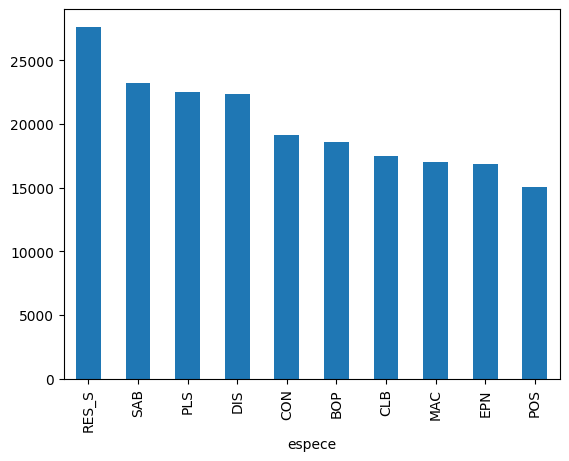

In [39]:
#plot distribution ofPOE_TOT by 'espece'
POE_TOT['espece'].value_counts().sort_values(ascending=False)[:10].plot(kind='bar')

### Extract location data from raster

In [4]:
import rasterio
import rasterio.features
from shapely.geometry import Point
from rasterio.transform import rowcol

def add_raster_values_to_geodf(raster_path, geodf, column_name='raster_value'):
    """
    Extract raster values at GeoDataFrame point geometries and add as a new column.
    
    Parameters:
    ----------
    raster_path : str
        Path to the raster file (.tif, etc)
    geodf : geopandas.GeoDataFrame
        GeoDataFrame with Point geometries
    column_name : str, optional
        Name for the new column(s) with raster values
        
    Returns:
    -------
    geopandas.GeoDataFrame
        Input GeoDataFrame with added raster value column(s)
    """
    # Open the raster
    with rasterio.open(raster_path) as src:
        
        # # Transform the GeoDataFrame to the raster's CRS if needed
        # if geodf.crs != src.crs:
        #     print(f"Transforming GeoDataFrame CRS from {geodf.crs} to {src.crs}.")
        #     geodf.to_crs(src.crs)
        
        # Check if we have a multi-band raster
        multi_band = src.count > 1
        
        # Create columns for each band if multi-band raster
        if multi_band:
            print("Multi-band raster detected.")
            column_names = [f"{column_name}_{i+1}" for i in range(src.count)]
            for col in column_names:
                geodf[col] = np.nan
        else:
            geodf[column_name] = np.nan
        
        # Extract the coordinates from the geometries
        for idx, geom in geodf.iterrows():
            # Check if the geometry is a Point or Polygon
            if geom.geometry.geom_type == 'Point':
                x, y = geom.geometry.x, geom.geometry.y
            elif geom.geometry.geom_type == 'Polygon':
                centroid = geom.geometry.centroid
                x, y = centroid.x, centroid.y
            else:
                print(f"Unsupported geometry type: {geom.geometry.geom_type}")
                continue
            
            # Convert coordinates to pixel indices
            row, col = rowcol(src.transform, x, y)
            
            # Check if the point is within the raster bounds
            if 0 <= row < src.height and 0 <= col < src.width:
                # For multi-band raster
                if multi_band:
                    for band in range(src.count):
                        value = src.read(band+1, window=((row, row+1), (col, col+1)))[0, 0]
                        # Handle nodata values
                        if value == src.nodata:
                            value = np.nan
                        geodf.at[idx, column_names[band]] = value
                # For single-band raster
                else:
                    value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                    # Handle nodata values
                    if value == src.nodata:
                        value = np.nan
                    geodf.at[idx, column_name] = value
        
        return geodf

In [5]:
import os

folder_path = '../data/data_layers'
file_paths = []
file_names = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        file_paths.append(full_path)
        file_names.append(os.path.splitext(file)[0])

In [23]:
#take the first elem different elem of no_poe and create a df of 10 unique of those elem
no_poe = POE_TOT['no_viree'].unique()
unique_no_viree_df = POE_TOT_reduced.drop_duplicates(subset='no_viree').head(10)


In [17]:
POE_TOT

,OGC_FID,id_poe,espece,rec,no_prj,no_viree,no_poe,id_viree,chainage,feuillet,latitude,longitude,date_sond,geometry
0,1,9002600101,ACM,0.1,90026,001,01,90026001,100,31F14SE,45.819832,-77.019622,1990-06-13,POINT (-77.01962 45.81983)
1,2,9002600101,ARN,0.1,90026,001,01,90026001,100,31F14SE,45.819832,-77.019622,1990-06-13,POINT (-77.01962 45.81983)
2,3,9002600101,ASM,3.0,90026,001,01,90026001,100,31F14SE,45.819832,-77.019622,1990-06-13,POINT (-77.01962 45.81983)
3,4,9002600101,BOP,0.2,90026,001,01,90026001,100,31F14SE,45.819832,-77.019622,1990-06-13,POINT (-77.01962 45.81983)
4,5,9002600101,BOV,0.1,90026,001,01,90026001,100,31F14SE,45.819832,-77.019622,1990-06-13,POINT (-77.01962 45.81983)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870446,870447,9900206905,SAB,3.0,99002,069,05,99002069,1500,12J12NE,50.665337,-59.636569,1999-07-20,POINT (-59.63657 50.66534)
870447,870448,9900206905,SPF,3.0,99002,069,05,99002069,1500,12J12NE,50.665337,-59.636569,1999-07-20,POINT (-59.63657 50.66534)
870448,870449,9900206905,SPS,0.1,99002,069,05,99002069,1500,12J12NE,50.665337,-59.636569,1999-07-20,POINT (-59.63657 50.66534)
870449,870450,9900206905,TRB,3.0,99002,069,05,99002069,1500,12J12NE,50.665337,-59.636569,1999-07-20,POINT (-59.63657 50.66534)


Had issues with the landuse data since it was not in the same projection as the other data. I used the `gdalwarp` command to reproject the landuse data to match the other data. The command is as follows:

```
gdalwarp -s_srs EPSG:32198 -t_srs EPSG:4326 -co "COMPRESS=LZW" utilisation_territoire_2020.tif output_raster.tif 
```

In [20]:
for i, file_path in enumerate(file_paths):
    print(f"Processing {file_path}")
    col_name = file_names[i]
    add_raster_values_to_geodf(
        raster_path=file_path,
        geodf=POE_TOT,
        column_name=col_name
    )

Processing ../data/data_layers/soil_grid/Umbrisols.tif
Processing ../data/data_layers/soil_grid/Chernozems.tif
Processing ../data/data_layers/soil_grid/Cryosols.tif
Processing ../data/data_layers/soil_grid/Regosols.tif
Processing ../data/data_layers/soil_grid/Gleysols.tif
Processing ../data/data_layers/soil_grid/Leptosols.tif
Processing ../data/data_layers/soil_grid/Gypsisols.tif
Processing ../data/data_layers/soil_grid/Solonchaks.tif
Processing ../data/data_layers/soil_grid/Nitisols.tif
Processing ../data/data_layers/soil_grid/Arenosols.tif
Processing ../data/data_layers/soil_grid/Andosols.tif
Processing ../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif
Processing ../data/data_layers/soil_grid/Ferralsols.tif
Processing ../data/data_layers/soil_grid/Phaeozems.tif
Processing ../data/data_layers/soil_grid/Vertisols.tif
Processing ../data/data_layers/soil_grid/Alisols.tif
Processing ../data/data_layers/soil_grid/Podzols.tif


KeyboardInterrupt: 

In [35]:
unique_no_viree_df

,OGC_FID,id_poe,espece,rec,no_prj,no_viree,no_poe,id_viree,chainage,feuillet,...,clipped_wc2.1_30s_bio_17,clipped_wc2.1_30s_bio_14,quebec_clipped_wc2.1_30s_elev,clipped_wc2.1_30s_bio_10,clipped_wc2.1_30s_bio_6,clipped_wc2.1_30s_bio_1,clipped_wc2.1_30s_bio_12,clipped_wc2.1_30s_bio_5,clipped_wc2.1_30s_bio_8,clipped_wc2.1_30s_bio_9
2690,2691,9201100801,AME,0.1,92011,008,01,92011008,200,31I02SO,...,0.518519,0.500000,9.0,0.897083,0.454545,0.895375,0.528710,0.904762,0.946150,0.431579
2847,2848,9201101001,ARN,3.0,92011,010,01,92011010,25,31H15NO,...,0.521886,0.500000,24.0,0.925446,0.461039,0.906010,0.543624,0.930403,0.963764,0.429386
3059,3060,9201108701,AME,0.1,92011,087,01,92011087,200,31H15SO,...,0.542088,0.520833,32.0,0.922204,0.477273,0.912689,0.574198,0.926740,0.961751,0.439912
3287,3288,9301000101,ARN,33.0,93010,001,01,93010001,50,31I03SE,...,0.531987,0.520833,17.0,0.940843,0.483766,0.927529,0.529456,0.941392,0.973327,0.450439
3469,3470,9301000201,ARA,0.1,93010,002,01,93010002,75,31H14NE,...,0.535354,0.531250,19.0,0.923015,0.474026,0.910957,0.528710,0.930403,0.962255,0.439035
3667,3668,9301000301,ARN,3.0,93010,003,01,93010003,300,31H14NE,...,0.542088,0.531250,25.0,0.922204,0.470779,0.908484,0.549590,0.926740,0.961751,0.435088
3861,3862,9301000401,ARA,0.1,93010,004,01,93010004,100,31H14SE,...,0.572391,0.541667,20.0,0.932739,0.493506,0.933218,0.542878,0.937729,0.968294,0.454386
4072,4073,9301000501,ARM,0.1,93010,005,01,93010005,100,31H14SE,...,0.548822,0.531250,31.0,0.923825,0.480519,0.914420,0.566741,0.926740,0.962758,0.441228
4314,4315,9301000601,ARA,0.1,93010,006,01,93010006,125,31H14SE,...,0.555556,0.531250,29.0,0.929498,0.483766,0.923077,0.563013,0.926740,0.966281,0.446491
4560,4561,9301000701,ACR,0.1,93010,007,01,93010007,125,31H14SO,...,0.542088,0.520833,22.0,0.933550,0.487013,0.925798,0.527219,0.937729,0.968797,0.588597


In [153]:
#save to csv
unique_no_viree_df.to_csv('POE_TOT_raster_values.csv', index=False)

### Extract h3 hex from location

In [4]:
def group_by_h3_cell1(df, h3_col='h3_index', species_col='species'):
    geo_df = gpd.GeoDataFrame(data=None, columns=['geometry', h3_col, 'count', species_col])
    
    # Group by h3_cell and aggregate - ensure flat lists
    grouped = df.groupby(h3_col).agg({
        species_col: [
            'nunique', 
            lambda x: x.tolist()  # This creates a flat list directly
        ]
    }).reset_index()

    # Flatten the MultiIndex columns
    grouped.columns = [h3_col, 'species_count', 'species_list']

    print(grouped['species_count'].sum())

    # Convert all items to strings and ensure flat list
    grouped['species_list'] = grouped['species_list'].apply(
        lambda x: [str(item) for item in (x if isinstance(x, (list, np.ndarray)) else [x])]
    )

    # Merge the geometry back into the grouped DataFrame
    grouped = grouped.merge(geo_df[[h3_col]], on=h3_col, how='left')

    # Merge the grouped DataFrame back into the geo_df
    geo_df = pd.concat([geo_df, grouped], ignore_index=True)

    # Final aggregation - flatten all species lists and get unique values
    geo_df = geo_df.groupby(h3_col).agg({
        'species_list': lambda x: list(set(item for sublist in x for item in sublist))
    }).reset_index()
    
    geo_df['species_count'] = geo_df['species_list'].apply(len)
    
    return geo_df

In [7]:
#generate h3 index
POE_TOT_reduced['h3_index'] = POE_TOT_reduced.geometry.apply(lambda point: geo_to_h3(point.y, point.x, 12))

#group by h3 index and species
processed_species = group_by_h3_cell1(POE_TOT_reduced, h3_col='h3_index', species_col='espece')

# #add the hex geometry for each h3_cell
processed_species = gpd.GeoDataFrame(
    processed_species,
    geometry=processed_species.apply(lambda x: add_geometry({'h3_cell': x['h3_index']}), axis=1),
    crs="EPSG:4326"
)

/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


157702


In [12]:
#Working with only a subsample of the data
import rasterio
import rasterio.plot
from shapely.geometry import box

raster_path = "../data/data_layers/soil_grid/Solonetz.tif"
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Read the first band of the raster
    my_extent = rasterio.plot.plotting_extent(src)  # Get the extent of the raster
    print(my_extent)

    # Create a bounding box from the extent
    bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])

    # Filter rows where geometry is completely inside the bounding box
    processed_species = processed_species[processed_species.geometry.within(bounding_box)]

(-75.665588, -70.894775, 45.26328900000001, 47.31834500000001)


In [16]:
#create a gpd df with unique value of h3_index
POE_TOT_h3 = processed_species.groupby('h3_index').first().reset_index()

In [16]:
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping, box, Polygon
import rasterio
import numpy as np

def get_clipped_bounds(out_image, out_transform):
    height, width = out_image.shape[-2:]
    left, top = rasterio.transform.xy(out_transform, 0, 0)
    right, bottom = rasterio.transform.xy(out_transform, height, width)
    return (left, bottom, right, top) 

def extract_raster_values_for_h3(geometry, raster_path):
    with rasterio.open(raster_path) as src:
        # Reproject geometry to match raster CRS
        h3_geometry = gpd.GeoSeries([geometry], crs="EPSG:4326")
        h3_geometry = h3_geometry.to_crs(src.crs)
        
        # Get raster resolution
        res_x, res_y = src.res
        
        # Check if hexagon is smaller than raster resolution
        hex_area = h3_geometry[0].area
        pixel_area = abs(res_x * res_y)
        
        if hex_area < pixel_area:
            # Hex is smaller than a pixel - use point sampling instead
            centroid = h3_geometry[0].centroid
            try:
                row, col = src.index(centroid.x, centroid.y)
                # Read single value - fixed parenthesis issue here
                value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                # Create a 1x1 array with the value
                out_image = np.array([[[value]]])
                # Create a transform for this single point
                left, top = src.xy(row, col)
                right, bottom = src.xy(row+1, col+1)
                out_transform = src.window_transform(((row, row+1), (col, col+1)))
                clipped_bounds = (left, bottom, right, top)
                return out_image, clipped_bounds
            except (IndexError, ValueError):
                raise ValueError("Hexagon centroid is outside raster bounds or could not be sampled")
        
        # Convert to GeoJSON
        geometry_proj = mapping(h3_geometry[0])
        
        # Create a bounding box from the raster bounds
        raster_bounds = box(*src.bounds)
        
        # Check overlap
        if not raster_bounds.intersects(h3_geometry[0]):
            raise ValueError("Geometry does not overlap the raster bounds.")
        
        try:
            # Mask the raster
            out_image, out_transform = mask(
                src, 
                [geometry_proj], 
                crop=True,
                filled=True,
                #nodata=np.nan
                nodata = src.nodata
            )
            
            # Check if we got all NaN values (might still happen)
            if np.all(np.isnan(out_image)):
                # Fall back to point sampling at centroid
                centroid = h3_geometry[0].centroid
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                out_image = np.array([[[value]]])
                left, top = src.xy(row, col)
                right, bottom = src.xy(row+1, col+1)
                out_transform = src.window_transform(((row, row+1), (col, col+1)))
            
            clipped_bounds = get_clipped_bounds(out_image, out_transform)
            return out_image, clipped_bounds
            
        except ValueError as e:
            if "Input shapes do not overlap raster" in str(e):
                raise ValueError("Geometry does not overlap the raster bounds.")
            raise

### Cutting data layers into hexagons

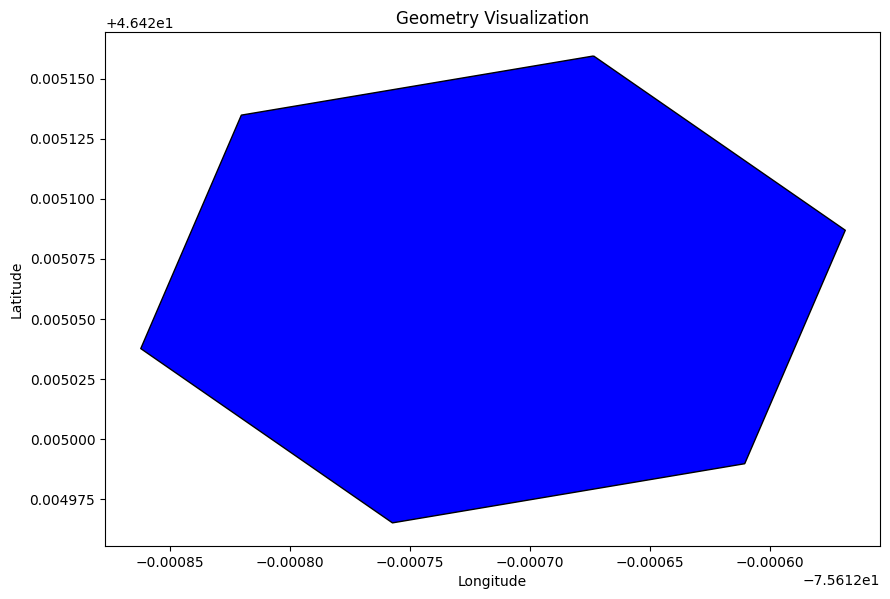

In [27]:
import matplotlib.pyplot as plt

# Select a row from processed_species
row_geometry = processed_species.iloc[0]['geometry']

# Plot the geometry
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoSeries(row_geometry).plot(ax=ax, color='blue', edgecolor='black')
plt.title('Geometry Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [81]:
my_extent

(-75.665588, -70.894775, 45.26328900000001, 47.31834500000001)

(np.float64(-75.665588), np.float64(-70.89892133333333), np.float64(45.26001166666668), np.float64(47.31834500000001))


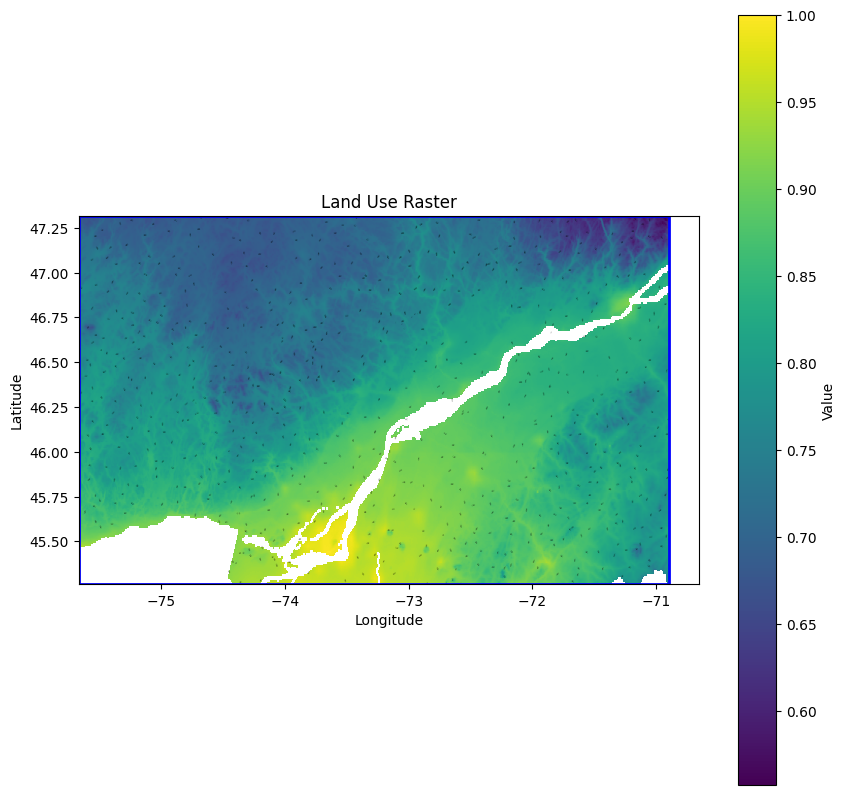

In [15]:
import rasterio
from rasterio.plot import plotting_extent
from rasterio.windows import from_bounds

import matplotlib.pyplot as plt


geom = processed_species['geometry']

# Open the raster file
#raster_path = "../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif"
#raster_path = "../data/data_layers/soil_grid/Solonetz.tif"
raster_path = "../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif"
with rasterio.open(raster_path) as src:
    window = from_bounds(left = reduced_extent[0], bottom = reduced_extent[2], right=reduced_extent[1], top=reduced_extent[3], transform=src.transform)
    # Read the data within the window
    raster_data = src.read(1, window=window)  # Read the first band of the raster
    window_transform = src.window_transform(window)
    extent = rasterio.plot.plotting_extent(raster_data, window_transform)  # Get the extent of the raster
    print(extent)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', extent=extent)
# Plot the geometry on top of the raster
# Ensure geom contains individual geometries
if isinstance(geom, gpd.GeoSeries):
    geom_to_plot = geom
else:
    geom_to_plot = gpd.GeoSeries(geom)

# Plot the geometry on top of the raster
geom_to_plot.plot(ax=plt.gca(), color='red', edgecolor='black', alpha=0.5)

# Plot the bounding box on the figure
bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs="EPSG:4326")
bounding_box_gdf.boundary.plot(ax=plt.gca(), color='blue', linewidth=2, label='Bounding Box')

# Add a colorbar
plt.colorbar(label='Value')
plt.title('Land Use Raster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

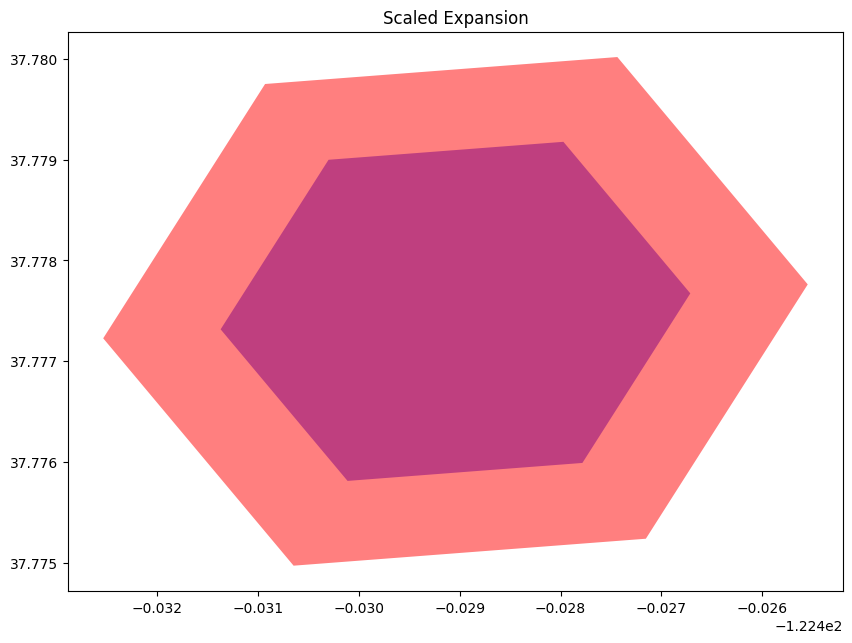

In [9]:
import matplotlib.pyplot as plt

import h3
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.affinity import scale

def expand_hexagon(h3_index, expansion_factor):
    """
    Uniformly expands a hexagon by scaling from its centroid
    
    Args:
        h3_index: H3 hexagon index
        expansion_factor: Multiplier for expansion (1.1 = 10% larger)
    
    Returns:
        Expanded Polygon geometry
    """
    # Get hexagon boundary as list of (lat,lng) points
    hex_boundary = h3.cell_to_boundary(h3_index)

    flipped = tuple(coord[::-1] for coord in hex_boundary)
    
    # Create Shapely polygon
    hex_poly = Polygon(flipped)
    
    # Scale the polygon from its centroid
    expanded_poly = scale(hex_poly, 
                         xfact=expansion_factor, 
                         yfact=expansion_factor, 
                         origin='centroid')
    
    return expanded_poly

def plot_hexagons(original, expanded, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    gpd.GeoSeries([original]).plot(ax=ax, color='blue', alpha=0.5)
    gpd.GeoSeries([expanded]).plot(ax=ax, color='red', alpha=0.5)
    plt.title(title)
    plt.show()

# Example visualization
hex_id = '89283082837ffff'
original_hex = h3.cell_to_boundary(hex_id)
original_hex = tuple(coord[::-1] for coord in original_hex)
# Create Shapely polygon
original_hex = Polygon(original_hex)

# Compare different methods
expanded_scale = expand_hexagon(hex_id, 1.5)

plot_hexagons(original_hex, expanded_scale, "Scaled Expansion")

In [44]:
def vis_one_band_raster(out_images, clipped_bounds, side_by_side=False):
    """
    Visualize multiple single-band raster images.

    Parameters:
    ----------
    out_images : list of numpy.ndarray
        List of raster images to visualize.
    clipped_bounds : tuple
        Tuple containing the bounds (left, bottom, right, top) for the extent.
    side_by_side : bool, optional
        If True, plots the images side by side. Otherwise, overlays them.
    """
    left, bottom, right, top = clipped_bounds
    extent = (left, right, bottom, top)
    
    fig, axes = plt.subplots(1, len(out_images), figsize=(15, 10))
    for i, out_image in enumerate(out_images):
        ax = axes[i] if len(out_images) > 1 else axes
        im = ax.imshow(
            out_image[0], 
            cmap='viridis', 
            extent=extent
        )
        ax.set_title(f'Raster {i+1}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        #cbar = plt.colorbar(im, ax=ax, orientation='vertical')
        #cbar.set_label('Normalized Value')

    plt.show()
# Define a function to normalize each band using percentiles
def normalize_band(band, min_percentile=2, max_percentile=98):
    if band.size == 0:
        raise ValueError("Band is empty")
    vmin = np.percentile(band, min_percentile)  # Lower bound
    vmax = np.percentile(band, max_percentile)  # Upper bound
    band = np.clip(band, vmin, vmax)  # Clip values outside percentile range
    return (band - vmin) / (vmax - vmin)  # Normalize to [0, 1]

def vis_rgb_raster(out_image, clipped_bounds):
    # Access the elements of the tuple directly
    left, bottom, right, top = clipped_bounds
    plt.figure(figsize=(10, 10))
    extent = (left, right, bottom, top)
    
    rgb_image = np.stack([
            normalize_band(out_image[0]),  # Normalize Red
            normalize_band(out_image[1]),  # Normalize Green
            normalize_band(out_image[2])   # Normalize Blue
    ], axis=-1)
    plt.imshow(rgb_image, extent=extent)
    plt.title('RGB Composite')
    

POLYGON ((-75.59260378150911 46.513694795441104, -75.59275079450593 46.51367016636451, -75.59279280992746 46.5135728753308, -75.59268781285995 46.513500213510284, -75.59254080039895 46.513524842473984, -75.59249878446965 46.5136221333711, -75.59260378150911 46.513694795441104))


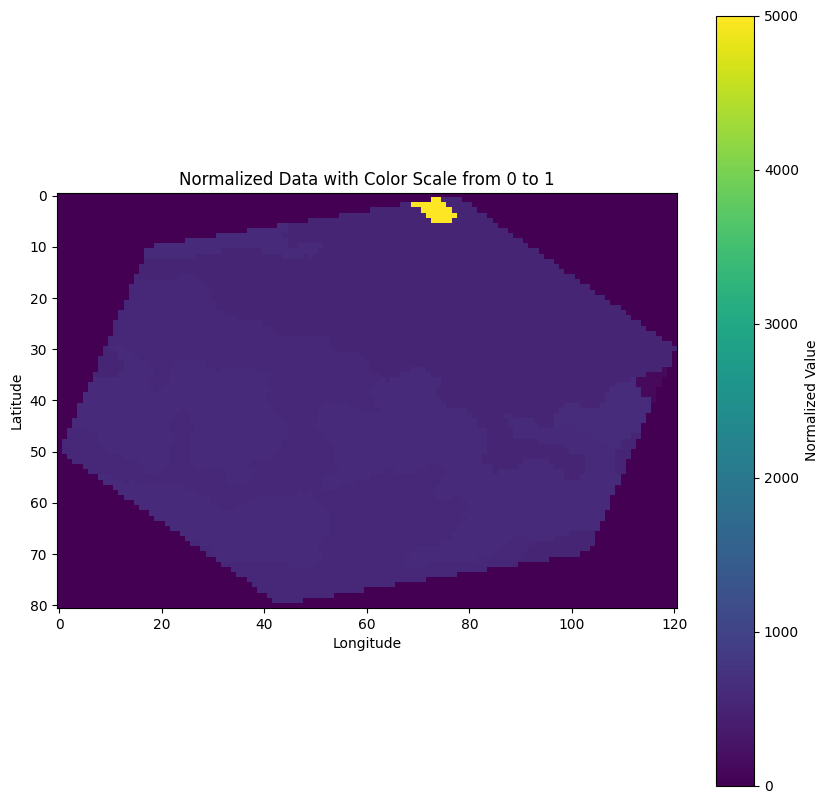

In [249]:
import matplotlib.pyplot as plt

geom = processed_species['geometry'].values[40]
h3_cell = processed_species['h3_index'].values[40]
expanded_geom = expand_hexagon(h3_cell, 50)  # Expand the hexagon by 10% of its size
#print(expanded_geom)
print(geom)
#out_image, clipped_bounds = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif")
out_image, clipped_bounds = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif")


# Plot the normalized data with color scale from 0 to 1
vis_one_band_raster(out_image, clipped_bounds)
# Plot the RGB composite
#vis_rgb_raster(out_image, clipped_bounds)

In [19]:
geom = processed_species.iloc[1000]
add_raster_values_to_geodf(
        raster_path="../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif",
        geodf=processed_species[1000:1001],
        column_name=col_name
)

NameError: name 'col_name' is not defined

In [382]:
stats = ['min', 'max', 'mean']
proc_spec = processed_species.copy()
z_stats = zonal_stats(
                vectors=processed_species['geometry'].values[1000:1001],
                raster="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif",
                stats=stats,
                #layer=1,
                all_touched=False, 
                )
z_stats

[{'min': None, 'max': None, 'mean': None}]

In [380]:
# Calculate zonal statistics
from rasterstats import zonal_stats

stats = ['min', 'max', 'mean']
proc_spec = processed_species.copy()
z_stats = zonal_stats(
                vectors=expand_hexagon(proc_spec['h3_index'].values[1000:1001][0], 50),
                raster="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif",
                stats=stats,
                #layer=1,
                all_touched=False, 
                )

In [381]:
z_stats

[{'min': 207.0, 'max': 330.0, 'mean': 252.0482233502538}]

In [333]:
z_stats

[{'min': 164.0, 'max': 289.0, 'mean': 198.96354166666666}]

### Extracting zonal stats from hexagons


In [20]:
#read csv
import pandas as pd
land_use_labels = pd.read_csv('../data/misc/utilisation_territoire_labels.csv')

In [21]:
category_map = dict(zip(land_use_labels['CODE_UT'].astype(float), land_use_labels['Classe détaillée']))

In [274]:
proc_spec = processed_species.copy()
geom = proc_spec['geometry'].values[0:10]

In [ ]:
# # Calculate zonal statistics
# from rasterstats import zonal_stats


# #concat the category map with proc_spec
# z_stats = zonal_stats(
#         vectors=proc_spec['geometry'].values,
#         raster='../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif',
#         layer=1,
#         all_touched=False,
#         categorical=True,
#         category_map = category_map,    
#                 )
# # Convert to DataFrame
# z_stats_df = pd.DataFrame(z_stats)
# # Add the h3_index to the DataFrame
# z_stats_df['h3_index'] = proc_spec['h3_index'].values

# # #save to csv
# z_stats_df.to_csv('cat_zonal_stats_res_13.csv', index=False)

In [ ]:
# # Calculate zonal statistics
# from rasterstats import zonal_stats

# stats = ['mean', 'min', 'max']
# proc_spec = processed_species.copy()
# #remove utilisation_territoire_2020_reprojected from the list of file_paths
# file_paths_t = [f for f in file_paths if 'utilisation_territoire_2020_reprojected' not in f]
# for i, file_path in enumerate(file_paths_t):
#         col_name = file_names[i]
#         print(f"Processing {file_path}")
#         z_stats = zonal_stats(
#                         vectors=proc_spec['geometry'].values,
#                         raster=file_path,
#                         stats=stats,
#                         layer=1,
#                         all_touched=False,
#                 )
#         # Convert z_stats into a DataFrame
#         z_stats_df = pd.DataFrame(z_stats)

#         # Add the statistics to processed_species
#         proc_spec = proc_spec.iloc[:len(z_stats)].copy()  # Ensure lengths match
#         # Add mean, min, and max columns only if stats are available
#         proc_spec[f'{col_name}_mean'] = z_stats_df.get('mean', np.nan)
#         proc_spec[f'{col_name}_min'] = z_stats_df.get('min', np.nan)
#         proc_spec[f'{col_name}_max'] = z_stats_df.get('max', np.nan)
# #save df
# proc_spec.to_csv('zonal_stats_res_13.csv', index=False)

Processing ../data/data_layers/soil_grid/Umbrisols.tif
Processing ../data/data_layers/soil_grid/Chernozems.tif
Processing ../data/data_layers/soil_grid/Cryosols.tif
Processing ../data/data_layers/soil_grid/Regosols.tif
Processing ../data/data_layers/soil_grid/Gleysols.tif
Processing ../data/data_layers/soil_grid/Leptosols.tif
Processing ../data/data_layers/soil_grid/Gypsisols.tif
Processing ../data/data_layers/soil_grid/Solonchaks.tif
Processing ../data/data_layers/soil_grid/Nitisols.tif
Processing ../data/data_layers/soil_grid/Arenosols.tif
Processing ../data/data_layers/soil_grid/Andosols.tif
Processing ../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif
Processing ../data/data_layers/soil_grid/Ferralsols.tif
Processing ../data/data_layers/soil_grid/Phaeozems.tif
Processing ../data/data_layers/soil_grid/Vertisols.tif
Processing ../data/data_layers/soil_grid/Alisols.tif
Processing ../data/data_layers/soil_grid/Podzols.tif
Processing ../data/data_layers/soil_grid/Fluvisols.tif
Process

In [170]:
from rasterstats import zonal_stats
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import time

def get_centroid_value(geometry, raster_path):
    """Get raster value at geometry's centroid"""
    with rasterio.open(raster_path) as src:
        # Reproject geometry to match raster CRS
        geom = gpd.GeoSeries([geometry], crs="EPSG:4326").to_crs(src.crs)[0]
        centroid = geom.centroid
        
        try:
            row, col = src.index(centroid.x, centroid.y)
            value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
            return value
        except (IndexError, ValueError):
            return np.nan
def get_centroid_values(geometries, raster_path):
    """Get raster values at geometries' centroids"""
    with rasterio.open(raster_path) as src:
        # Reproject geometries to match raster CRS
        geom_series = gpd.GeoSeries(geometries, crs="EPSG:4326").to_crs(src.crs)
        
        values = []
        for geom in geom_series:
            centroid = geom.centroid
            try:
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                values.append(value)
            except (IndexError, ValueError):
                values.append(np.nan)
        return values

def should_use_centroid(geometries, raster_path, sample_size=5):
    """Check if we should use centroid sampling for this raster"""
    with rasterio.open(raster_path) as src:
        # Get raster resolution
        res_x, res_y = src.res
        pixel_area = abs(res_x * res_y)
        
        # Check sample of geometries
        sample_idx = np.random.choice(len(geometries), min(sample_size, len(geometries)), replace=False)
        sample_geoms = gpd.GeoSeries([geometries[i] for i in sample_idx], crs="EPSG:4326").to_crs(src.crs)
        
        # Count how many are smaller than a pixel
        small_count = sum(1 for geom in sample_geoms if geom.area < pixel_area)
        return small_count / len(sample_geoms) > 0.8  # Use centroid if >80% are small

# Main processing function
def process_rasters(proc_spec, file_paths, file_names, category_map=None):
    # Prepare results storage
    continuous_data = {}
    categorical_data = {'h3_index': proc_spec['h3_index'].values}
    
    for i, file_path in enumerate(file_paths):
        col_name = file_names[i]
        #print(f"Processing {file_path}")
        
        # Special handling for categorical raster
        if 'utilisation_territoire' in file_path:
            if should_use_centroid(proc_spec['geometry'].values, file_path):
                # Centroid sampling for categorical data
                #values = [get_centroid_value(geom, file_path) for geom in proc_spec['geometry'].values]
                values = get_centroid_values(proc_spec['geometry'].values, file_path)
                categorical_data['landuse_value'] = values
                #categorical_data['landuse_method'] = ['centroid'] * len(values)
                
                # Map category numbers to names
                if category_map:
                    categorical_data['landuse_category'] = [
                        category_map.get(int(val), 'Unknown') if not np.isnan(val) else 'Unknown' 
                        for val in values
                    ]

            else:
                # Proper categorical zonal stats
                start = time.time()
                z_stats = zonal_stats(
                    vectors=proc_spec['geometry'].values,
                    raster=file_path,
                    categorical=True,
                    category_map=category_map,
                    all_touched=False
                )
                end = time.time()
                print(f"Zonal stats took {end - start:.2f} seconds")
                start = time.time()
                # Flatten categorical results
                for idx, stats in enumerate(z_stats):
                    for cat, count in stats.items():
                        if cat != 'h3_index':
                            col = f'landuse_{cat}'
                            if col not in categorical_data:
                                categorical_data[col] = [0] * len(z_stats)
                            categorical_data[col][idx] = count
                end = time.time()
                print(f"Flattening took {end - start:.2f} seconds")
                #categorical_data['landuse_method'] = ['zonal_stats'] * len(z_stats)
        else:
            # Continuous raster processing
            if should_use_centroid(proc_spec['geometry'].values, file_path):
                # Centroid sampling
                #values = [get_centroid_value(geom, file_path) for geom in proc_spec['geometry'].values]
                values = get_centroid_values(proc_spec['geometry'].values, file_path)
                continuous_data[f'{col_name}_value'] = values
                #continuous_data[f'{col_name}_method'] = ['centroid'] * len(values)
            else:
                # Zonal stats
                z_stats = zonal_stats(
                    vectors=proc_spec['geometry'].values,
                    raster=file_path,
                    stats=['mean', 'min', 'max'],
                    all_touched=False
                )
                
                continuous_data[f'{col_name}_value'] = [s.get('mean', np.nan) for s in z_stats]
                continuous_data[f'{col_name}_min'] = [s.get('min', np.nan) for s in z_stats]
                continuous_data[f'{col_name}_max'] = [s.get('max', np.nan) for s in z_stats]
    
    # Create final DataFrames
    continuous_df = gpd.GeoDataFrame(
        {**continuous_data, 'geometry': proc_spec['geometry'].values},
        crs="EPSG:4326"
    )
    continuous_df['h3_index'] = proc_spec['h3_index'].values
    
    categorical_df = pd.DataFrame(categorical_data)
    categorical_df['h3_index'] = proc_spec['h3_index'].values
    
    return continuous_df, categorical_df

In [171]:
# Execute processing
continuous_results, categorical_results = process_rasters(
    proc_spec=processed_species.copy(),
    file_paths=file_paths,  # Include all file paths
    file_names=file_names,
    category_map=category_map
)

# # Save results
# continuous_results.to_csv('continuous_zonal_stats_res_12.csv', index=False)
# categorical_results.to_csv('cat_zonal_stats_res_12.csv', index=False)

Zonal stats took 14.83 seconds
Flattening took 0.00 seconds


In [165]:
#add h3_index column to continuous_results
continuous_results

,Umbrisols_value,Chernozems_value,Cryosols_value,Regosols_value,Gleysols_value,Leptosols_value,Gypsisols_value,Solonchaks_value,Nitisols_value,Arenosols_value,...,quebec_clipped_wc2.1_30s_elev_value,clipped_wc2.1_30s_bio_10_value,clipped_wc2.1_30s_bio_6_value,clipped_wc2.1_30s_bio_1_value,clipped_wc2.1_30s_bio_12_value,clipped_wc2.1_30s_bio_5_value,clipped_wc2.1_30s_bio_8_value,clipped_wc2.1_30s_bio_9_value,geometry,h3_index
0,0,1,0,1,8,0,0,0,0,0,...,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61267 46.42516, -75.61282 46.425...",8c2b80005b121ff
1,0,1,0,1,10,0,0,0,0,0,...,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.60915 46.42512, -75.6093 46.4250...",8c2b80005b233ff
2,0,0,0,1,9,0,0,0,0,0,...,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61594 46.42515, -75.61609 46.425...",8c2b80005b959ff
3,0,0,0,1,12,1,0,0,0,0,...,310,0.820097,0.337662,0.774425,0.546607,0.882784,0.898339,0.374561,"POLYGON ((-75.57214 46.48563, -75.57229 46.485...",8c2b800241617ff
4,0,1,0,1,17,1,0,0,0,0,...,271,0.824149,0.344156,0.784566,0.536913,0.882784,0.900856,0.380263,"POLYGON ((-75.57171 46.48065, -75.57185 46.480...",8c2b800243209ff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,0,0,0,0,14,0,0,0,0,0,...,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.63106 47.11539, -72.63121 47.115...",8c2baedb2c0b9ff
4615,0,0,0,0,16,0,0,0,0,0,...,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.62938 47.11293, -72.62953 47.112...",8c2baedb2c4a5ff
4616,0,0,0,0,14,0,0,0,0,0,...,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.63029 47.11442, -72.63045 47.114...",8c2baedb2c50bff
4617,0,0,0,0,11,0,0,0,0,1,...,273,0.803079,0.340909,0.750928,0.588367,0.853480,0.887770,0.370614,"POLYGON ((-72.63361 47.11916, -72.63376 47.119...",8c2baedb2d817ff


In [420]:
def post_process_continuous(continuous_df):
    """
    Simplifies continuous results DataFrame by removing redundant columns when 
    min, max and value (mean) are identical for the same raster.
    
    Parameters:
    -----------
    continuous_df : GeoDataFrame
        The continuous results DataFrame with columns in format:
        {raster_name}_value, {raster_name}_min, {raster_name}_max, etc.
    
    Returns:
    --------
    GeoDataFrame
        Simplified DataFrame with redundant columns removed
    """
    # Make a copy to avoid modifying the original
    df = continuous_df.copy()
    
    # Identify all unique raster base names
    columns = [col for col in df.columns if not col in ['geometry', 'h3_index']]
    raster_names = list(set([col.split('_')[0] for col in columns if '_value' in col or '_min' in col or '_max' in col]))
    
    columns_to_drop = []
    
    for raster in raster_names:
        value_col = f"{raster}_value"
        min_col = f"{raster}_min"
        max_col = f"{raster}_max"
        
        # Check if all three columns exist
        if all(col in df.columns for col in [value_col, min_col, max_col]):
            
            # Check if all values are identical across the three columns
            if (df[value_col] == df[min_col]).all() and (df[value_col] == df[max_col]).all():
                print(f"All values are identical for {raster}. Dropping min and max columns.")
                # Mark min and max columns for removal
                columns_to_drop.extend([min_col, max_col])
                
                # Update method column if exists
                method_col = f"{raster}_method"
                if method_col in df.columns:
                    df[method_col] = df[method_col].replace({'zonal_stats': 'single_value'})
    
    # Drop redundant columns
    df = df.drop(columns=columns_to_drop)
    
    return df
# Usage example:
simplified_df = post_process_continuous(continuous_results)
#simplified_df.to_csv('simplified_continuous_stats.csv', index=False)

In [455]:
simplified_df

,Umbrisols_value,Chernozems_value,Cryosols_value,Regosols_value,Gleysols_value,Leptosols_value,Gypsisols_value,Solonchaks_value,Nitisols_value,Arenosols_value,...,clipped_wc2.1_30s_bio_14_value,quebec_clipped_wc2.1_30s_elev_value,clipped_wc2.1_30s_bio_10_value,clipped_wc2.1_30s_bio_6_value,clipped_wc2.1_30s_bio_1_value,clipped_wc2.1_30s_bio_12_value,clipped_wc2.1_30s_bio_5_value,clipped_wc2.1_30s_bio_8_value,clipped_wc2.1_30s_bio_9_value,geometry
0,0,1,0,1,8,0,0,0,0,0,...,0.510417,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61282 46.4251, -75.61287 46.4250..."
1,0,1,0,1,10,0,0,0,0,0,...,0.510417,289,0.824960,0.350649,0.787039,0.535421,0.882784,0.901359,0.384211,"POLYGON ((-75.60914 46.42501, -75.60919 46.424..."
2,0,0,0,1,9,0,0,0,0,0,...,0.510417,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61599 46.42509, -75.61604 46.425..."
3,0,0,0,1,12,1,0,0,0,0,...,0.510417,310,0.820097,0.337662,0.774425,0.546607,0.882784,0.898339,0.374561,"POLYGON ((-75.57224 46.48562, -75.57229 46.485..."
4,0,1,0,1,17,1,0,0,0,0,...,0.500000,271,0.824149,0.344156,0.784566,0.536913,0.882784,0.900856,0.380263,"POLYGON ((-75.57165 46.48059, -75.5717 46.4805..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,1,6,0,0,0,0,0,...,0.520833,360,0.774716,0.298701,0.716547,0.571216,0.853480,0.838450,0.498246,"POLYGON ((-75.01388 47.05253, -75.01393 47.052..."
996,0,0,0,1,9,0,0,0,0,0,...,0.510417,343,0.777958,0.298701,0.720257,0.565996,0.853480,0.840463,0.500000,"POLYGON ((-75.01707 47.05069, -75.01712 47.050..."
997,0,0,0,1,12,0,0,0,0,0,...,0.520833,360,0.774716,0.298701,0.716547,0.571216,0.853480,0.838450,0.498246,"POLYGON ((-75.01234 47.0535, -75.01238 47.0534..."
998,0,0,0,0,15,0,0,0,0,1,...,0.520833,360,0.774716,0.298701,0.716547,0.571216,0.853480,0.838450,0.498246,"POLYGON ((-75.01142 47.05405, -75.01147 47.054..."


#### Extracting zonal stats for regions

From my tests its useless to expand less than 10x since the raster resolution is pretty low

In [174]:
import numpy as np

# Create an array starting at 1.25 and multiply each term by 1.25 until it exceeds 5
factors = 1.25 * np.array([1.25**i for i in range(int(np.log(8/1.25)/np.log(1.25)) + 1)])
print(factors)


[1.25       1.5625     1.953125   2.44140625 3.05175781 3.81469727
 4.76837158 5.96046448 7.4505806 ]


In [176]:
for factor in factors:
    print(f"Processing with factor: {factor}")
    #Execute processing
    proc_spec = processed_species.copy()
    #15x is the minimum size to get zonal stats on gridsoil and satelitte data
    proc_spec['geometry'] = proc_spec['h3_index'].apply(lambda h3_index: expand_hexagon(h3_index, factor))

    continuous_results_x10, categorical_results_x10 = process_rasters(
        proc_spec=proc_spec.copy(),
        file_paths=file_paths,  # Include all file paths
        file_names=file_names,
        category_map=category_map
    )

    # Save results
    continuous_results_x10.to_csv(f'../data/misc/continuous_zonal_stats_res_12_x{factor}.csv', index=False)
    categorical_results_x10.to_csv(f'../data/misc/cat_zonal_stats_res_12.csv_x{factor}.csv', index=False)

Processing with factor: 1.25
Zonal stats took 15.87 seconds
Flattening took 0.00 seconds
Processing with factor: 1.5625
Zonal stats took 17.34 seconds
Flattening took 0.01 seconds
Processing with factor: 1.953125
Zonal stats took 19.35 seconds
Flattening took 0.00 seconds
Processing with factor: 2.44140625
Zonal stats took 21.41 seconds
Flattening took 0.00 seconds
Processing with factor: 3.0517578125
Zonal stats took 24.38 seconds
Flattening took 0.00 seconds
Processing with factor: 3.814697265625
Zonal stats took 27.99 seconds
Flattening took 0.00 seconds
Processing with factor: 4.76837158203125
Zonal stats took 32.38 seconds
Flattening took 0.01 seconds
Processing with factor: 5.9604644775390625
Zonal stats took 37.78 seconds
Flattening took 0.01 seconds
Processing with factor: 7.450580596923828
Zonal stats took 44.45 seconds
Flattening took 0.01 seconds


In [27]:
# Save results
continuous_results_x10.to_csv('continuous_zonal_stats_res_12_x10.csv', index=False)
categorical_results_x10.to_csv('cat_zonal_stats_res_12.csv_x10.csv', index=False)

In [439]:
continuous_results_x10

,Umbrisols_value,Chernozems_value,Cryosols_value,Regosols_value,Gleysols_value,Leptosols_value,Gypsisols_value,Solonchaks_value,Nitisols_value,Arenosols_value,...,clipped_wc2.1_30s_bio_14_value,quebec_clipped_wc2.1_30s_elev_value,clipped_wc2.1_30s_bio_10_value,clipped_wc2.1_30s_bio_6_value,clipped_wc2.1_30s_bio_1_value,clipped_wc2.1_30s_bio_12_value,clipped_wc2.1_30s_bio_5_value,clipped_wc2.1_30s_bio_8_value,clipped_wc2.1_30s_bio_9_value,geometry
0,0,1,0,1,8,0,0,0,0,0,...,0.510417,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61284 46.42544, -75.61332 46.425..."
1,0,1,0,1,10,0,0,0,0,0,...,0.510417,289,0.824960,0.350649,0.787039,0.535421,0.882784,0.901359,0.384211,"POLYGON ((-75.60917 46.42535, -75.60965 46.425..."
2,0,0,0,1,9,0,0,0,0,0,...,0.510417,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61602 46.42544, -75.61649 46.425..."
3,0,0,0,1,12,1,0,0,0,0,...,0.510417,310,0.820097,0.337662,0.774425,0.546607,0.882784,0.898339,0.374561,"POLYGON ((-75.57227 46.48597, -75.57275 46.485..."
4,0,1,0,1,17,1,0,0,0,0,...,0.500000,271,0.824149,0.344156,0.784566,0.536913,0.882784,0.900856,0.380263,"POLYGON ((-75.57168 46.48094, -75.57216 46.480..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0,0,0,0,14,0,0,0,0,0,...,0.531250,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.63101 47.11568, -72.63151 47.115..."
4616,0,0,0,0,16,0,0,0,0,0,...,0.531250,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.62938 47.11328, -72.62988 47.113..."
4617,0,0,0,0,14,0,0,0,0,0,...,0.531250,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.63035 47.11471, -72.63085 47.114..."
4618,0,0,0,0,11,0,0,0,0,1,...,0.552083,273,0.803079,0.340909,0.750928,0.588367,0.853480,0.887770,0.370614,"POLYGON ((-72.63356 47.11945, -72.63406 47.119..."


In [ ]:
# # Apply the expansion function to the h3_index column and update the geometry
# stats = ['mean', 'min', 'max']
# proc_spec = processed_species.copy()
# proc_spec['geometry'] = proc_spec['h3_index'].apply(lambda h3_index: expand_hexagon(h3_index, 10))

# #concat the category map with proc_spec
# z_stats = zonal_stats(
#         vectors=proc_spec['geometry'].values,
#         raster='../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif',
#         layer=1,
#         all_touched=True,
#         categorical=True,
#         category_map = category_map,    
#                 )
# # Convert to DataFrame
# z_stats_df = pd.DataFrame(z_stats)
# # Add the h3_index to the DataFrame
# z_stats_df['h3_index'] = proc_spec['h3_index'].values

# # #save to csv
# z_stats_df.to_csv('cat_zonal_stats_res_13_regions_x10.csv', index=False)

In [ ]:
# stats = ['mean', 'min', 'max']
# proc_spec = processed_species.copy()
# proc_spec['geometry'] = proc_spec['h3_index'].apply(lambda h3_index: expand_hexagon(h3_index, 10))
# #remove utilisation_territoire_2020_reprojected from the list of file_paths
# file_paths_t = [f for f in file_paths if 'utilisation_territoire_2020_reprojected' not in f]
# for i, file_path in enumerate(file_paths_t):
#         col_name = file_names[i]
#         print(f"Processing {file_path}")
#         z_stats = zonal_stats(
#                         vectors=proc_spec['geometry'].values,
#                         raster=file_path,
#                         stats=stats,
#                         layer=1,
#                         all_touched=True,
#                 )
#         # Convert z_stats into a DataFrame
#         z_stats_df = pd.DataFrame(z_stats)

#         # Add the statistics to processed_species
#         proc_spec = proc_spec.iloc[:len(z_stats)].copy()  # Ensure lengths match
#         # Add mean, min, and max columns only if stats are available
#         proc_spec[f'{col_name}_mean'] = z_stats_df.get('mean', np.nan)
#         proc_spec[f'{col_name}_min'] = z_stats_df.get('min', np.nan)
#         proc_spec[f'{col_name}_max'] = z_stats_df.get('max', np.nan)
# #save df
# proc_spec.to_csv('zonal_stats_res_13.csv_regions_x10', index=False)

Processing ../data/data_layers/soil_grid/Umbrisols.tif
Processing ../data/data_layers/soil_grid/Chernozems.tif
Processing ../data/data_layers/soil_grid/Cryosols.tif
Processing ../data/data_layers/soil_grid/Regosols.tif
Processing ../data/data_layers/soil_grid/Gleysols.tif
Processing ../data/data_layers/soil_grid/Leptosols.tif
Processing ../data/data_layers/soil_grid/Gypsisols.tif
Processing ../data/data_layers/soil_grid/Solonchaks.tif
Processing ../data/data_layers/soil_grid/Nitisols.tif
Processing ../data/data_layers/soil_grid/Arenosols.tif
Processing ../data/data_layers/soil_grid/Andosols.tif
Processing ../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif
Processing ../data/data_layers/soil_grid/Ferralsols.tif
Processing ../data/data_layers/soil_grid/Phaeozems.tif
Processing ../data/data_layers/soil_grid/Vertisols.tif
Processing ../data/data_layers/soil_grid/Alisols.tif
Processing ../data/data_layers/soil_grid/Podzols.tif
Processing ../data/data_layers/soil_grid/Fluvisols.tif
Process

### Preparing data for model


In [30]:
# Extract unique base column names by removing the suffix (_min, _max, _mean)
base_column_names = set(col.rsplit('_', 1)[0] for col in zonal_stats.columns if col.endswith(('_min', '_max', '_mean')))

# Initialize a dictionary to store the count of rows with differing values
diff_counts = {}

# Iterate over each base column name
for base_name in base_column_names:
    # Extract the min, max, and mean columns for the base name
    min_col = f"{base_name}_min"
    max_col = f"{base_name}_max"
    mean_col = f"{base_name}_mean"
    
    # Check if all three columns exist in the DataFrame
    if all(col in zonal_stats.columns for col in [min_col, max_col, mean_col]):
        # Count rows where the values are different
        diff_rows = zonal_stats[(zonal_stats[min_col] != zonal_stats[max_col]) | 
                                (zonal_stats[min_col] != zonal_stats[mean_col]) | 
                                (zonal_stats[max_col] != zonal_stats[mean_col])]
        diff_counts[base_name] = len(diff_rows)

# Display the results
for base_name, count in diff_counts.items():
    print(f"{base_name}: {count} rows have differing min, max, and mean values.")

In [135]:
from itertools import chain
from collections import Counter

# Extract species lists and flatten them while keeping words intact
all_species = list(chain.from_iterable(zonal_stats['species_list'].apply(lambda x: eval(x) if isinstance(x, str) else x)))

# Count the occurrences of each species
species_counts = Counter(all_species)

# Convert the counts to a DataFrame for easier plotting
species_counts_df = pd.DataFrame.from_dict(species_counts, orient='index', columns=['count'])

In [136]:
species_counts_df.sort_values(by='count', ascending=False).head(20)

,count
RES_S,4245
FEU_S,4230
SAB,3937
ERR,3372
DRS,3349
FEU_R,3061
MAC,3013
DIS,2971
CAX,2890
BOJ,2705


trying to find species that are not in all hexagons. The species ERP and POS are good candidates because they are in approximately 50% of the hexagons. So ill use them to prototype

In [ ]:
# #creating a df with a the h3_index and if the species ERP is present or not
# erp_present = zonal_stats[['species_list', 'h3_index']].copy()
# erp_present['ERP'] = erp_present['species_list'].apply(lambda x: 1 if 'ERP' in eval(x) else 0)

# pos_present = zonal_stats[['species_list', 'h3_index']].copy()
# pos_present['POS'] = pos_present['species_list'].apply(lambda x: 1 if 'POS' in eval(x) else 0)

In [15]:
#feature selection
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def create_target_species_df(species_name, location_zonal_stats):
    df_present = location_zonal_stats[['species_list', 'h3_index']].copy()
    # Use single brackets to get the Series and apply to each list directly
    df_present[species_name] = df_present['species_list'].apply(lambda x: 1 if species_name in x else 0)
    return df_present

def merge_data_inputs(df, location_zonal_stats, cat_location_zonal_stats, area_zonal_stats = None, cat_area_zonal_stats = None):
    merged_df = df.merge(location_zonal_stats, on='h3_index', how='left')

    # Merge the result with cat_zonal_stats
    merged_df = merged_df.merge(cat_location_zonal_stats, on='h3_index', how='left')
    if area_zonal_stats is not None and cat_area_zonal_stats is not None:
        merged_df = merged_df.merge(area_zonal_stats, on='h3_index', how='left')
        # Merge the result with cat_zonal_stats_x15
        merged_df = merged_df.merge(cat_area_zonal_stats, on='h3_index', how='left')

    merged_df.drop(columns=['species_list_x', 'species_list_y', 'h3_index'], inplace=True)
    # Display the merged DataFrame
    merged_df.replace(np.nan, 0, inplace=True)

    return merged_df

In [14]:

def select_features(merged_df, target, features):
    # Select features and target variable
    X = merged_df[features]
    y = merged_df[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # First train a model to get feature importances
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Create selector and transform - preserving feature names
    selector = SelectFromModel(model, prefit=True, threshold='median')

    # # Get selected features
    # selected_features = X_train.columns[selector.get_support()]

    # # Filter datasets using the selected features
    # X_train_selected = X_train[selected_features]
    # X_test_selected = X_test[selected_features]

    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    return X_train_selected, X_test_selected, y_train, y_test

Text(0.5, 1.0, 'Feature importances')

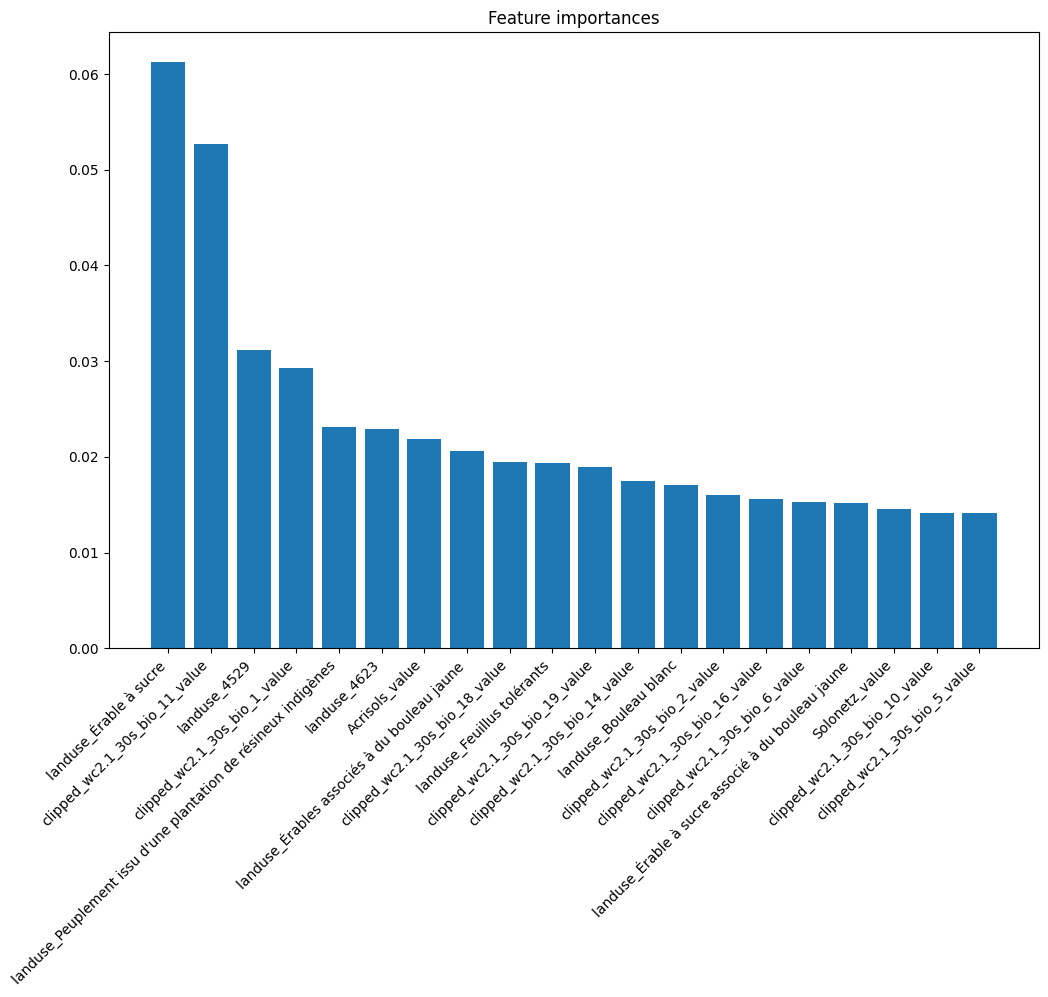

In [62]:
# # Feature importance
import matplotlib.pyplot as plt
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
top_n = 20  # Number of top features to display
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [features[i] for i in indices[:top_n]], rotation=45, ha="right")
plt.title("Feature importances")

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    #print("Model R^2 Score:", model.score(X_test, y_test))
    # Calculate accuracy
    accuracy = accuracy_score(y_test, np.round(y_pred))
    #print("Accuracy:", accuracy)
    train_accuracy = model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    return (accuracy, train_accuracy)

In [11]:
def evaluate_species(species_name, location_zonal_stats, cat_location_zonal_stats, area_zonal_stats = None, cat_area_zonal_stats = None):# Define the target variable and features
    target = species_name  # Replace with the actual target column if different
    features = create_target_species_df(target, location_zonal_stats)

    model = xgb.XGBClassifier(
        objective='binary:logistic',  # or 'multi:softmax' for multiclass
        n_estimators=75,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        colsample_bytree=0.7,
        subsample=0.4,
    )
    
    accuracy_with_region = None
    if area_zonal_stats is not None and cat_area_zonal_stats is not None:
        merged_df_with_region = merge_data_inputs(features, location_zonal_stats, cat_location_zonal_stats, area_zonal_stats, cat_area_zonal_stats)
        features_with_region = merged_df_with_region.select_dtypes(include=['float64', 'int64']).columns.drop(target)
        X_train_selected_with_region, X_test_selected_with_region, y_train_with_region, y_test_with_region = select_features(merged_df_with_region, target, features_with_region)
        accuracy_with_region, train_accuracy_with_region = evaluate_model(model, X_train_selected_with_region, y_train_with_region, X_test_selected_with_region, y_test_with_region)

    merged_df_without_region = merge_data_inputs(features,location_zonal_stats, cat_location_zonal_stats)
    features_without_region = merged_df_without_region.select_dtypes(include=['float64', 'int64']).columns.drop(target)
    X_train_selected_without_region, X_test_selected_without_region, y_train_without_region, y_test_without_region = select_features(merged_df_without_region, target, features_without_region)
    accuracy_without_region, train_accuracy_without_region = evaluate_model(model, X_train_selected_without_region, y_train_without_region, X_test_selected_without_region, y_test_without_region)
    
    return (accuracy_with_region, accuracy_without_region)

In [9]:
#load df
location_zonal_stats = pd.read_csv('../data/misc/continuous_zonal_stats_res_12.csv')
cat_location_zonal_stats = pd.read_csv('../data/misc/cat_zonal_stats_res_12.csv')
location_zonal_stats_numeric_columns = location_zonal_stats.select_dtypes(include=['float64', 'int64']).columns
location_zonal_stats[location_zonal_stats_numeric_columns] = location_zonal_stats[location_zonal_stats_numeric_columns].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
)
#merge zonal_stats with processed_species using h3_index
location_zonal_stats = location_zonal_stats.merge(
    processed_species[['h3_index', 'species_list']],
    on='h3_index',
    how='left'
)


def load_data_by_factor(factor):
        zonal_stats_x15 = pd.read_csv(f'../data/misc/continuous_zonal_stats_res_12_x{factor}.csv')
        cat_zonal_stats_x15 = pd.read_csv(f'../data/misc/cat_zonal_stats_res_12.csv_x{factor}.csv')

        # Normalize all numeric columns in zonal_stats between 0 and 1

        zonal_stats_x15_numeric_columns = zonal_stats_x15.select_dtypes(include=['float64', 'int64']).columns


        zonal_stats_x15[zonal_stats_x15_numeric_columns] = zonal_stats_x15[zonal_stats_x15_numeric_columns].apply(
            lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
        )
        return zonal_stats_x15, cat_zonal_stats_x15

In [17]:
import numpy as np

# Create an array starting at 1.25 and multiply each term by 1.25 until it exceeds 5
factors = 1.25 * np.array([1.25**i for i in range(int(np.log(8/1.25)/np.log(1.25)) + 1)])
print(factors)


#species_to_test = species_counts_df.sort_values(by='count', ascending=False).head(15).index.to_list()
species_to_test = ['ERS']
results = pd.DataFrame(columns=['Species', 'Accuracy', 'factor'])
for species in species_to_test:
    accuracy_with_region, accuracy_without_region = evaluate_species(species,location_zonal_stats, cat_location_zonal_stats)
    results = pd.concat([results, pd.DataFrame({
        'Species': [species],
        'Accuracy': [accuracy_without_region],
        'factor': [0]
    })], ignore_index=True)
    for factor in factors:
        area_zonal_stats, cat_area_zonal_stats = load_data_by_factor(factor)
        print(f"Processing {species} with factor: {factor}")
        accuracy_with_region, accuracy_without_region = evaluate_species(species,location_zonal_stats, cat_location_zonal_stats, area_zonal_stats, cat_area_zonal_stats)
        results = pd.concat([results, pd.DataFrame({
            'Species': [species],
            'Accuracy': [accuracy_with_region],
            'factor': [factor]
        })], ignore_index=True)

[1.25       1.5625     1.953125   2.44140625 3.05175781 3.81469727
 4.76837158 5.96046448 7.4505806 ]


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/tmp/ipykernel_8756/2058199435.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


Processing ERS with factor: 1.25


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 1.5625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 1.953125


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 2.44140625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 3.0517578125


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 3.814697265625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 4.76837158203125


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 5.9604644775390625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 7.450580596923828


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [18]:
# Select the row with the best accuracy for each species
best_accuracy_per_species = results.loc[results.groupby('Species')['Accuracy'].idxmax()]

# Ensure there is a row with factor == 0 for each species
accuracy_at_factor_0 = results[results['factor'] == 0].set_index('Species')['Accuracy']

# Calculate the difference between the best accuracy and the accuracy where factor == 0 for each species
best_accuracy_per_species['Accuracy_Difference'] = best_accuracy_per_species['Accuracy'] - best_accuracy_per_species['Species'].map(accuracy_at_factor_0)

# Display the result
best_accuracy_per_species

,Species,Accuracy,factor,Accuracy_Difference
5,ERS,0.83658,3.051758,0.017316


In [19]:
results

,Species,Accuracy,factor
0,ERS,0.819264,0
1,ERS,0.816017,1.25
2,ERS,0.831169,1.5625
3,ERS,0.819264,1.953125
4,ERS,0.834416,2.441406
5,ERS,0.836580,3.051758
6,ERS,0.834416,3.814697
7,ERS,0.824675,4.768372
8,ERS,0.832251,5.960464
9,ERS,0.834416,7.450581


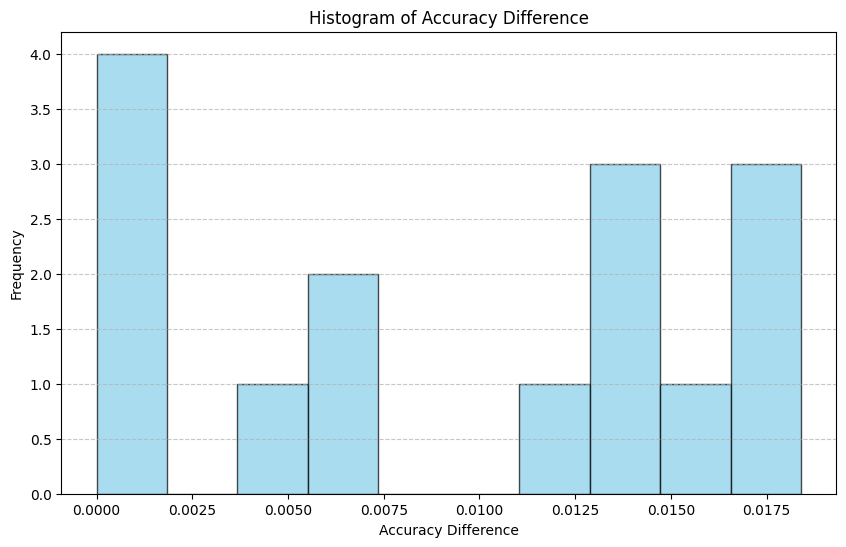

In [215]:
import matplotlib.pyplot as plt

# Plot Accuracy Difference as a histogram
plt.figure(figsize=(10, 6))
plt.hist(best_accuracy_per_species['Accuracy_Difference'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels, title, and grid
plt.xlabel('Accuracy Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Accuracy Difference')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


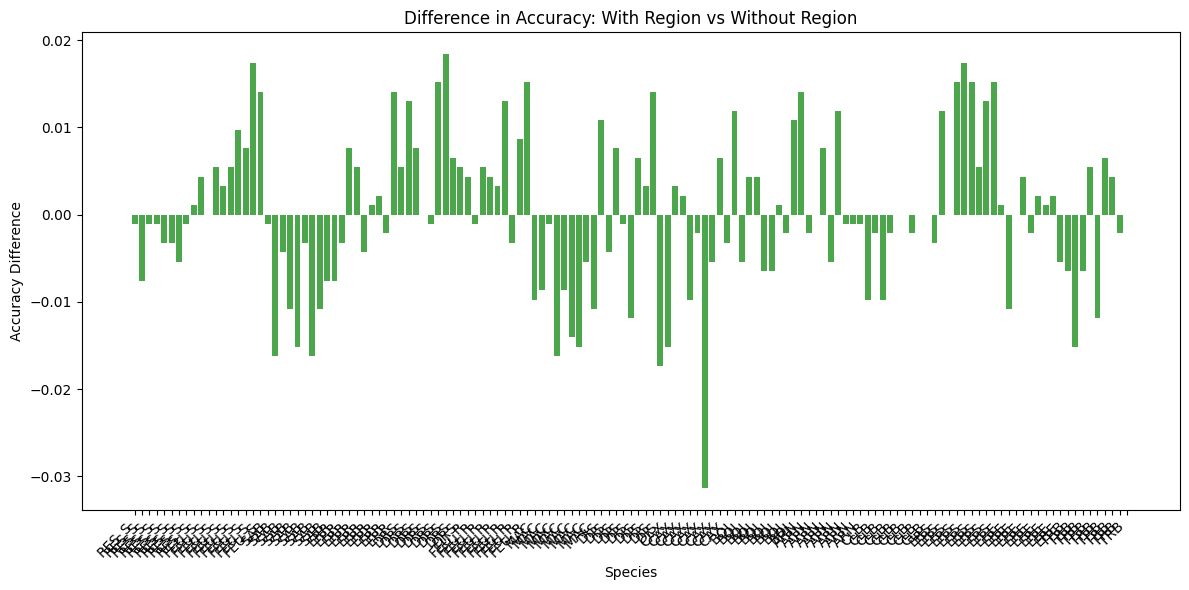

In [204]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the difference
results['Accuracy_Difference'] = results['Accuracy_With_Region'] - results['Accuracy_Without_Region']

# Set the positions of the bars
indices = np.arange(len(results))

# Plot the difference
plt.figure(figsize=(12, 6))
plt.bar(indices, results['Accuracy_Difference'], color='green', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Species')
plt.ylabel('Accuracy Difference')
plt.title('Difference in Accuracy: With Region vs Without Region')
plt.xticks(indices, results['Species'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56       244
           1       0.84      0.88      0.86       680

    accuracy                           0.78       924
   macro avg       0.72      0.70      0.71       924
weighted avg       0.77      0.78      0.78       924

[[126 118]
 [ 82 598]]


## Implementing 3D CNN

### Extracting data from hexagons

In [95]:
import rasterio
def extract_raster_values_for_multiple_h3(geometries, raster_path):
    with rasterio.open(raster_path) as src:
        # Reproject all geometries to match raster CRS
        h3_geometries = gpd.GeoSeries(geometries, crs="EPSG:4326")
        h3_geometries = h3_geometries.to_crs(src.crs)

        # Get raster resolution
        res_x, res_y = src.res
        pixel_area = abs(res_x * res_y)

        results = []

        for geometry in h3_geometries:
            # Check if hexagon is smaller than raster resolution
            hex_area = geometry.area

            if hex_area < pixel_area:
                # Hex is smaller than a pixel - use point sampling instead
                centroid = geometry.centroid
                try:
                    row, col = src.index(centroid.x, centroid.y)
                    value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                    out_image = np.array([[[value]]])
                    left, top = src.xy(row, col)
                    right, bottom = src.xy(row + 1, col + 1)
                    clipped_bounds = (left, bottom, right, top)
                    results.append((out_image, clipped_bounds))
                except (IndexError, ValueError):
                    results.append((None, None))
                continue

            # Convert to GeoJSON
            geometry_proj = mapping(geometry)

            # Create a bounding box from the raster bounds
            raster_bounds = box(*src.bounds)

            # Check overlap
            if not raster_bounds.intersects(geometry):
                results.append((None, None))
                continue

            try:
                # Mask the raster
                out_image, out_transform = mask(
                    src,
                    [geometry_proj],
                    crop=True,
                    filled=True,
                    nodata=src.nodata
                )

                # Check if we got all NaN values
                if np.all(np.isnan(out_image)):
                    centroid = geometry.centroid
                    row, col = src.index(centroid.x, centroid.y)
                    value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                    out_image = np.array([[[value]]])
                    left, top = src.xy(row, col)
                    right, bottom = src.xy(row + 1, col + 1)
                    out_transform = src.window_transform(((row, row + 1), (col, col + 1)))

                clipped_bounds = get_clipped_bounds(out_image, out_transform)
                results.append((out_image, clipped_bounds))

            except ValueError as e:
                if "Input shapes do not overlap raster" in str(e):
                    results.append((None, None))
                else:
                    raise

        return results


### Normalizing data
For the satelitte images, the resolution of hexagons are 73x110

For the landuse data, the resolution of hexagons are 161x241

For the climate data, the resolution of hexagons are 

Could be an interesting idea to test if a FCN produces better results since it can take multiple resolutions as input.

In [148]:
h3_cells = processed_species['h3_index'].values[:10]
expanded_cells = [expand_hexagon(h3_cell, 50) for h3_cell in h3_cells]

rgb_raster = extract_raster_values_for_multiple_h3(
        geometries=expanded_cells,
        raster_path="../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif",
        #raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif"
    )

In [149]:
output, bounds = rgb_raster[0]
output.shape

(1, 81, 121)

In [154]:
import numpy as np
from skimage.transform import resize

def resize_raster(input_raster, target_shape):
    """
    Resize the raster input_raster to the target shape using interpolation.   
    
    Parameters:
    - input_raster: The input raster array to be resized.
    - target_shape: The desired shape (height, width) for the output raster.
    
    Returns:
    - resized_image: The resized raster array.
    """
    # Assuming `output` is a 2D or 3D numpy array
    if len(input_raster.shape) == 2:
        # For single band raster
        resized_image = resize(input_raster, target_shape, order=1, anti_aliasing=True, mode='edge')  # bilinear
    elif len(input_raster.shape) == 3:
        # For multi-band raster
        resized_image = np.stack([
            resize(band, target_shape, order=1, anti_aliasing=True, mode='edge') for band in input_raster
        ], axis=-1)
    else:
        raise ValueError("Unsupported output shape: {}".format(input_raster.shape))
    
    return resized_image

output, bounds = rgb_raster[4] 
target_shape = (73, 110)
resized_image = resize_raster(output[0], target_shape)  # Resize to 100x100 pixels

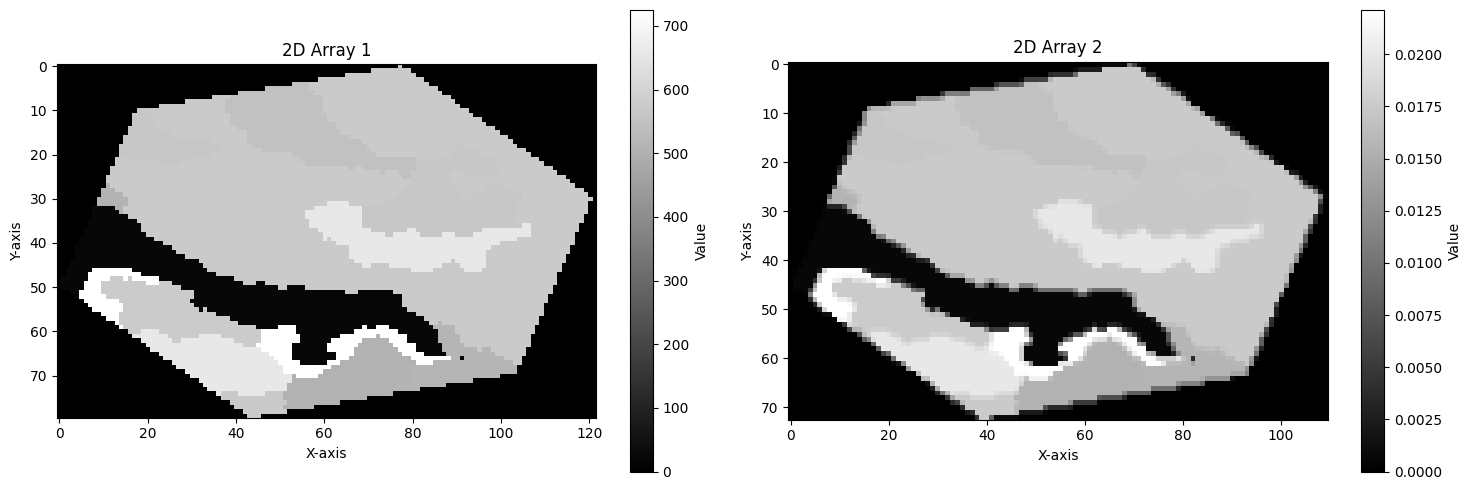

In [160]:
visualize_2d_array([output[0], resized_image])

In [144]:
import matplotlib.pyplot as plt

def visualize_2d_array(arrays):
    fig, axes = plt.subplots(1, len(arrays), figsize=(15, 5))
    # If there's only one array, wrap it in a list to handle it uniformly
    if len(arrays) == 1:
        arrays = [arrays[0]]
        axes = [axes]  # Wrap axes in a list to handle it uniformly
    for i, (array, ax) in enumerate(zip(arrays, axes)):
        im = ax.imshow(array, cmap='gray')  # You can change the colormap (e.g., 'viridis', 'gray', etc.)
        ax.set_title(f'2D Array {i+1}')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        fig.colorbar(im, ax=ax, orientation='vertical', label='Value')  # Add a colorbar to each subplot
    plt.tight_layout()
    plt.show()

Original shape: (109, 164)
Resized shape: (73, 110)


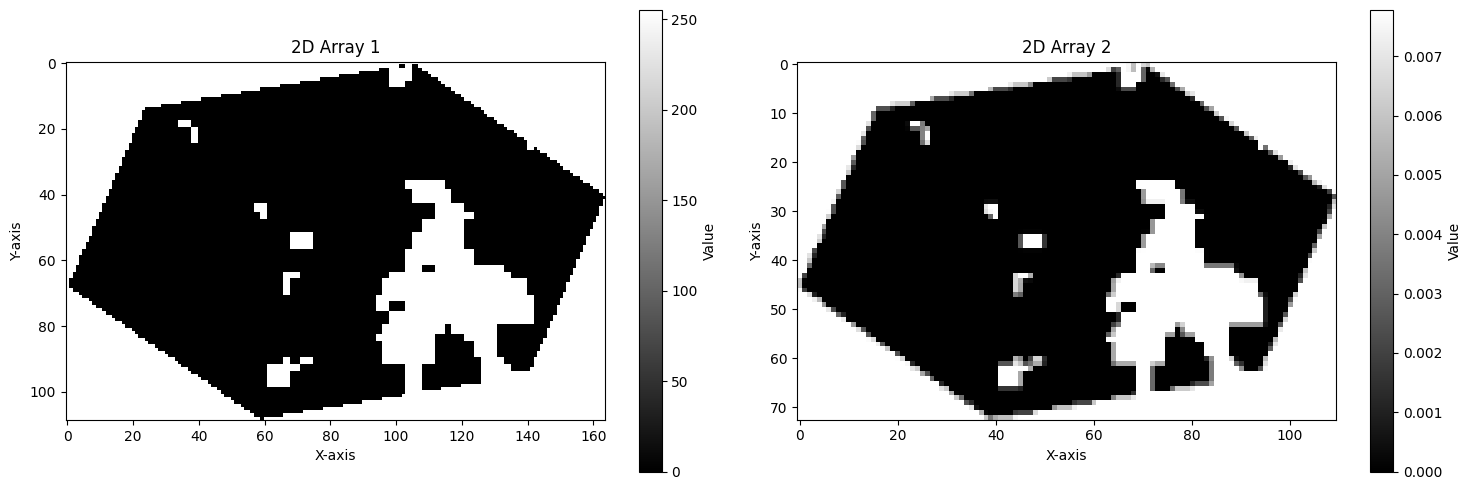

In [119]:
import numpy as np
from skimage.transform import resize

output, bounds = rgb_raster[4]
output = output[0]  # Assuming the first band is what you want to visualize
# Assuming `image` is your input array (73x110 or 161x241)
original_shape = output.shape
target_shape = (73, 110)  # or (73, 110) for downsampling

# Resize using interpolation (options: 'nearest', 'bilinear', 'bicubic', 'lanczos')
resized_image = resize(output, target_shape, order=1, anti_aliasing=True, mode='edge')  # bicubic

# For remote sensing, 'bilinear' (order=1) or 'bicubic' (order=3) are common
print("Original shape:", original_shape)
print("Resized shape:", resized_image.shape)
visualize_2d_array([output, resized_image])

In [169]:
def extract_all_bands_for_geom(geometries):
    rgb_raster = extract_raster_values_for_multiple_h3(
        geometries=geometries,
        raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif"
    )
    false_color_raster = extract_raster_values_for_multiple_h3(
        geometries=geometries,
        raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_FalseColor.tif"
    )
    swir_raster = extract_raster_values_for_multiple_h3(
        geometries=geometries,
        raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_SWIR.tif"
    )
    results = []
    for i, (rgb_output, bounds) in enumerate(rgb_raster):
        B4, B3, B2 = rgb_output
        B8 = false_color_raster[i][0][0]
        B11 = swir_raster[i][0][0]
        results.append(np.stack([B4, B3, B2, B8, B11]))
    return results

In [135]:
def extract_all_bands_for_uni_band(geometries, raster_paths):
    extracted_bands = []
    for raster_i, raster_path in enumerate(raster_paths):
        raster_values = extract_raster_values_for_multiple_h3(
            geometries=geometries,
            raster_path=raster_path
        )
        extracted_bands.append([])
        for i, (output, bounds) in enumerate(raster_values):
            if output is not None:
                extracted_bands[raster_i].append(output[0])  # Assuming single band output
            else:
                extracted_bands.append(None)
        
    return extracted_bands

In [ ]:
#fetch all files in the folders: ['../data/data_layers/soil_grid', '../data/data_layers/worldClim', '../data/data_layers/landuse']
import os
def fetch_raster_files(directories):
    raster_files = []
    for directory in directories:
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.tif'):
                    raster_files.append(os.path.join(root, file))
    return raster_files
# Define directories to search for raster files
directories = [
    '../data/data_layers/soil_grid',
    '../data/data_layers/worldClim',
    '../data/data_layers/landuse'
]

In [ ]:
h3_cells = processed_species['h3_index'].values
expanded_cells = [expand_hexagon(h3_cell, 100) for h3_cell in h3_cells]
raster_files = fetch_raster_files(directories)


In [197]:
def extract_resize_for_other_data(geometries, raster_paths, target_shape=(73, 110)):
    extracted_bands = extract_all_bands_for_uni_band(geometries, raster_paths)
    resized_bands = []  # Use a list instead of numpy array for appending
    for band in extracted_bands:
        resized_hex_arr = []  # Use a list for appending resized hexagons
        for hex_band in band:
            if hex_band is not None:  # Check if the band is not None
                resized_hex = resize_raster(hex_band, target_shape)
                resized_hex_arr.append(resized_hex)
            else:
                resized_hex_arr.append(None)  # Append None if the band is None
        resized_bands.append(resized_hex_arr)

    return np.swapaxes(np.array(resized_bands, dtype=object), 0,1)  # Convert the list to a numpy array if needed

In [208]:
extracted_bands = extract_resize_for_other_data(
    geometries=expanded_cells[:10],
    raster_paths=raster_files,
    target_shape=(73, 110)
)

In [209]:
extracted_bands.shape

(10, 50, 73, 110)

In [171]:
import numpy as np

def pad_or_crop_to_shape(array, target_shape):
    """
    Pads or crops a 3D array to the target shape.
    
    Parameters:
    ----------
    array : numpy.ndarray
        The input array to be padded or cropped.
    target_shape : tuple
        The target shape (height, width, depth).
    
    Returns:
    -------
    numpy.ndarray
        The array padded or cropped to the target shape.
    """
    current_shape = array.shape
    padded_array = np.zeros(target_shape, dtype=array.dtype)
    
    # Calculate the cropping or padding indices
    min_height = min(current_shape[0], target_shape[0])
    min_width = min(current_shape[1], target_shape[1])
    min_depth = min(current_shape[2], target_shape[2])
    
    # Copy the overlapping region
    padded_array[:min_height, :min_width, :min_depth] = array[:min_height, :min_width, :min_depth]
    
    return padded_array

In [172]:
h3_cells = processed_species['h3_index'].values[:100]
expanded_cells = [expand_hexagon(h3_cell, 100) for h3_cell in h3_cells]
extracted_bands = extract_all_bands_for_geom(expanded_cells)

#normalize shapes
# Determine the target shape (e.g., the maximum shape among all arrays)
target_shape = tuple(np.max([band.shape for band in extracted_bands], axis=0))

# Pad or crop all elements in extracted_bands to the target shape
extracted_bands = [pad_or_crop_to_shape(band, target_shape) for band in extracted_bands]


In [176]:
extracted_bands[0].shape

(5, 74, 111)

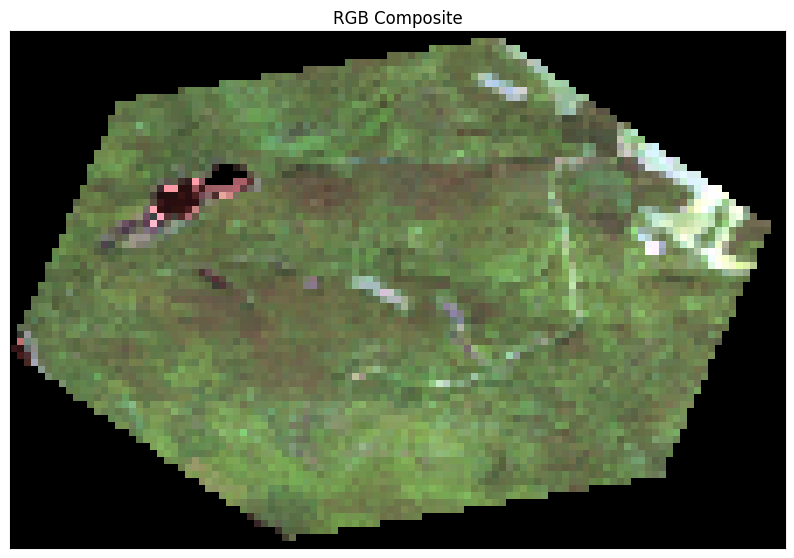

<Axes: title={'center': 'RGB Composite'}>

In [159]:
import earthpy.plot as ep

ep.plot_rgb(
    extracted_bands[5],
    rgb=(2, 1, 0),
    stretch=True,
    title="RGB Composite",
    figsize=(10, 10),
    str_clip= 0.2
)

### Extracting H3 bands

POLYGON ((-75.01934286056813 47.04929490295433, -75.01949196676215 47.04927092138622, -75.01953577067272 47.04917341771896, -75.01943046890267 47.04909989576222, -75.01928136326327 47.049123877221945, -75.01923755883931 47.049221380746815, -75.01934286056813 47.04929490295433))


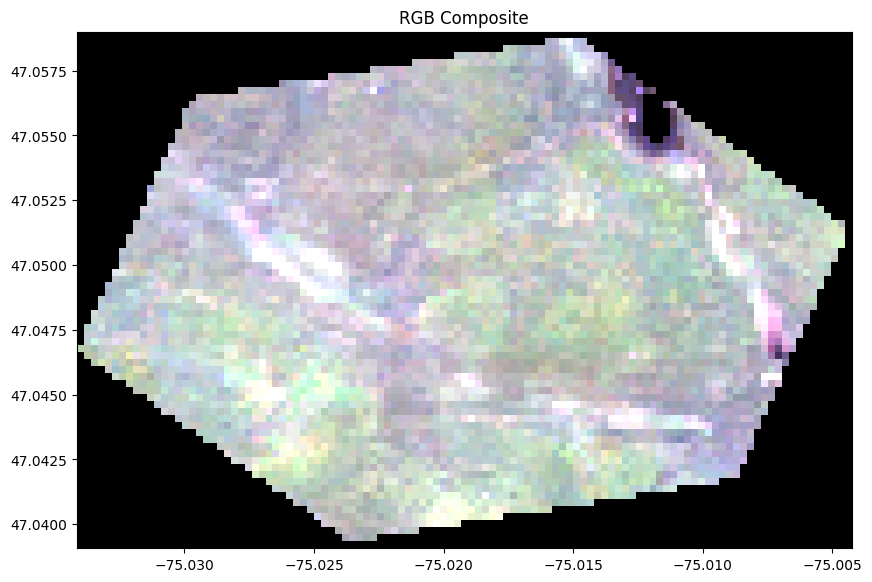

In [52]:
import matplotlib.pyplot as plt

geom = processed_species['geometry'].values[1000]
h3_cell = processed_species['h3_index'].values[1000]
expanded_geom = expand_hexagon(h3_cell, 100)  # Expand the hexagon by 10% of its size
#print(expanded_geom)
print(geom)
out_image_rgb, clipped_bounds_rgb = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif")
out_image_false_color, clipped_bounds_false_color = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_FalseColor.tif")
out_image_ndvi, clipped_bounds_ndvi = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_NDVI.tif")
out_image_swir, clipped_bounds_swir = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_SWIR.tif")
#out_image, clipped_bounds = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif")


# Plot the normalized data with color scale from 0 to 1
#vis_one_band_raster(out_image, clipped_bounds)
# Plot the RGB composite
vis_rgb_raster(out_image, clipped_bounds)

    # Define band combinations
    band_sets = {
        "RGB": ['B4', 'B3', 'B2'],
        "FalseColor": ['B8', 'B4', 'B3'],
        "SWIR": ['B11', 'B8'],
        "NDVI": ['NDVI'],
        "moisture": ['moisture']
    }

In [ ]:
def stack_bands()
B4 = out_image_rgb[0]
B3 = out_image_rgb[1]
B2 = out_image_rgb[2]
B8 = out_image_false_color[0]
B11 = out_image_swir[0]

# stackk all the bands
stacked_bands = np.stack([B4, B3, B2, B8, B11], axis=0)

In [57]:
stacked_bands.shape

(5, 74, 111)

In [78]:
# Calculate padding amounts (top/bottom)
pad_total = 111 - 74
pad_top = pad_total // 2
pad_bottom = pad_total - pad_top

def pad_band(band):
    # Pad height (axis=0), leave width (axis=1) unchanged
    padded_tile = np.pad(
        band,
        pad_width=((pad_top, pad_bottom), (0, 0)),  # Pad only height, no padding for width
        mode='constant',  # For zero-padding
        constant_values=0  # Or use `mode='reflect'`
    )
    return padded_tile

B2_padded = pad_band(B2)
B3_padded = pad_band(B3)
B4_padded = pad_band(B4)

stacked_bands_padded = np.stack([B4_padded, B3_padded, B2_padded], axis=0)

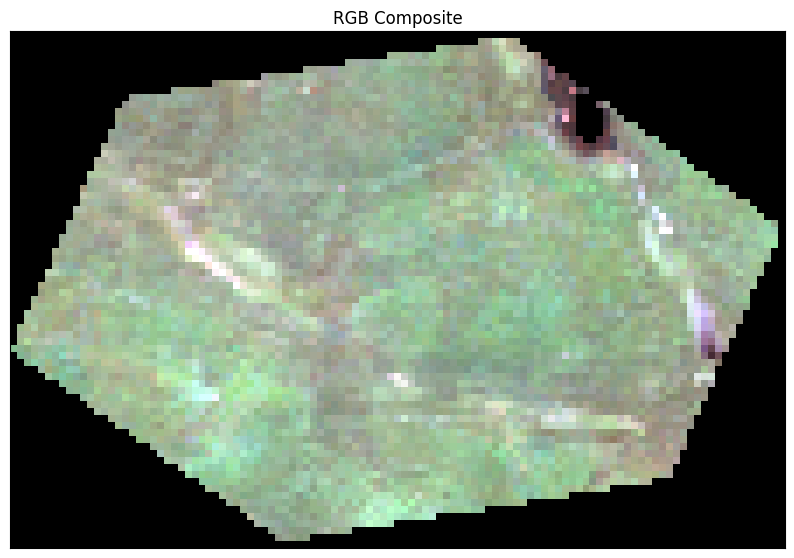

<Axes: title={'center': 'RGB Composite'}>

In [80]:
import earthpy.plot as ep

ep.plot_rgb(
    stacked_bands,
    rgb=(2, 1, 0),
    stretch=True,
    title="RGB Composite",
    figsize=(10, 10),
    str_clip= 0.2
)

### Data augmentation

In [195]:
stacked_bands.shape

(5, 74, 111)

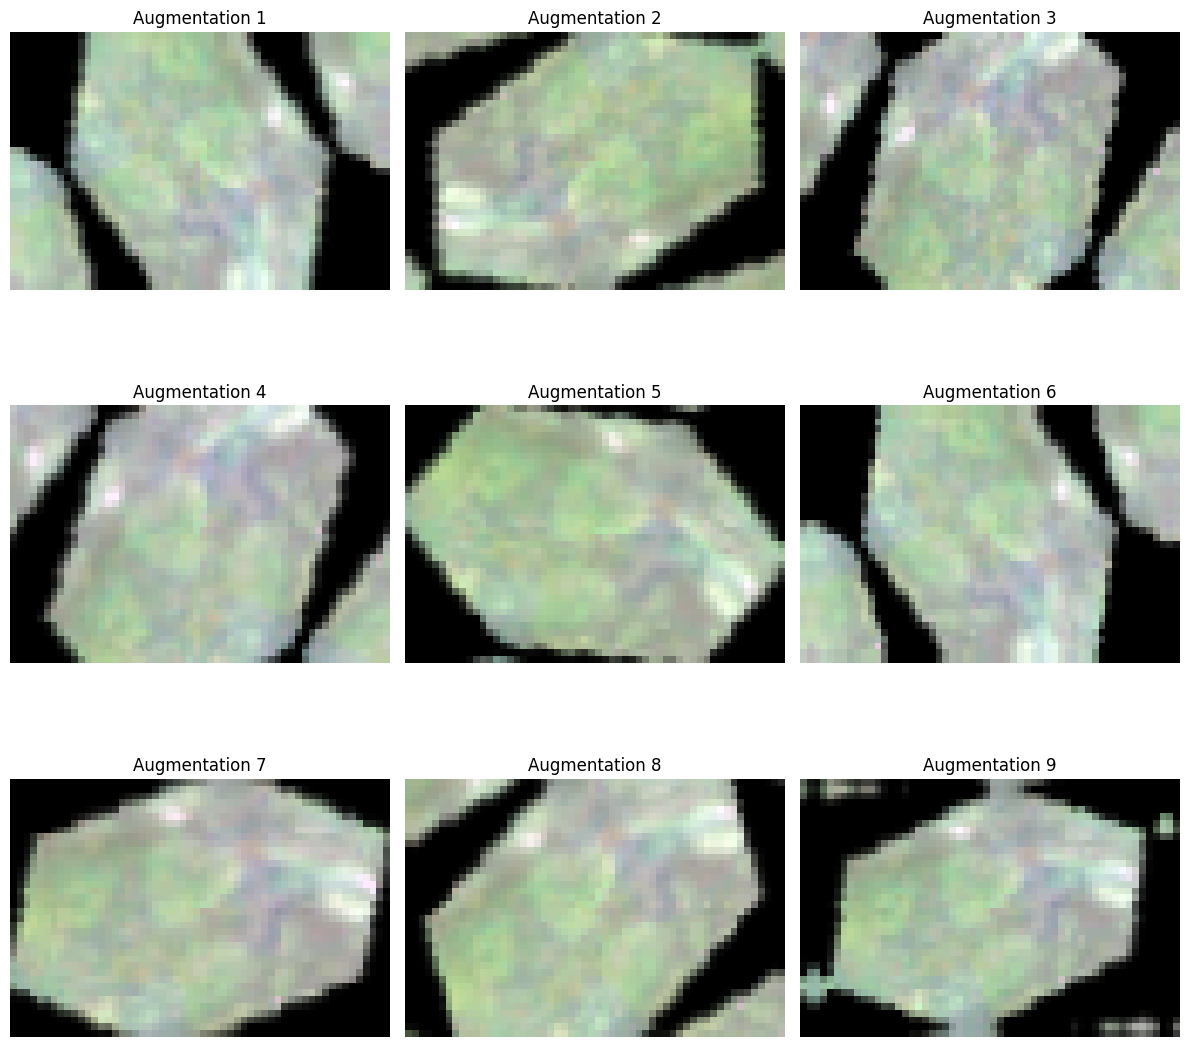

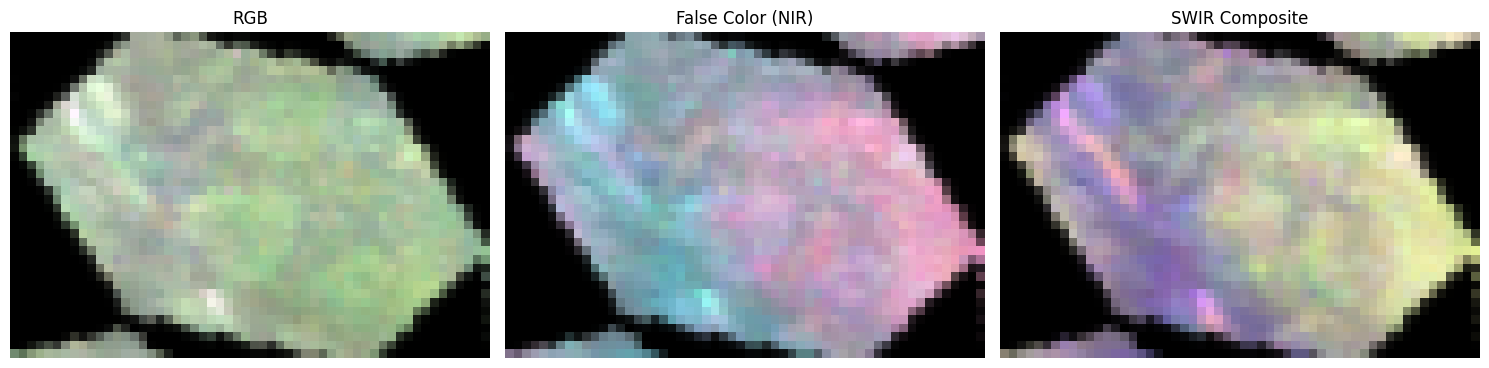

In [199]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Define augmentation sequence
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    # No intensity/brightness transformations since spectral values have physical meaning
])

# Function to visualize RGB composite from multispectral data
def visualize_rgb(image_array, band_indices=(0, 1, 2)):
    """
    Visualize RGB composite from bands in multispectral image
    
    Parameters:
    -----------
    image_array: Array with shape (bands, height, width) or (height, width, bands)
    band_indices: Tuple with indices for (R, G, B) bands
    """
    # Check if bands are in the first dimension
    if image_array.shape[0] < image_array.shape[-1]:
        # Convert from (bands, height, width) to (height, width, bands)
        image_array = np.transpose(image_array, (1, 2, 0))
    
    # Extract RGB bands
    rgb = image_array[:, :, band_indices]
    
    # Normalize for visualization
    rgb_norm = np.zeros_like(rgb, dtype=np.float32)
    for i in range(3):
        band = rgb[:, :, i]
        if np.max(band) > np.min(band):
            rgb_norm[:, :, i] = (band - np.min(band)) / (np.max(band) - np.min(band))
    
    return rgb_norm

# Rearrange to (height, width, bands) for Keras
#raster_data = np.transpose(stacked_bands, (1, 2, 0))

# Add batch dimension required by Keras
raster_batch = tf.convert_to_tensor(raster_data)
raster_batch = tf.expand_dims(raster_batch, 0)

# Apply augmentation and visualize results
plt.figure(figsize=(12, 12))
for i in range(9):
    # Generate a new augmented image for each plot
    augmented_image = data_augmentation(raster_batch, training=True)
    
    # Extract RGB bands for visualization
    rgb_display = visualize_rgb(augmented_image[0].numpy(), band_indices=(0, 1, 2))
    
    # Plot
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(rgb_display)
    plt.title(f"Augmentation {i+1}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

# If you want to visualize other band combinations (like False Color or SWIR)
plt.figure(figsize=(15, 5))
augmented_image = data_augmentation(raster_batch, training=True)

# RGB
plt.subplot(1, 3, 1)
plt.imshow(visualize_rgb(augmented_image[0].numpy(), band_indices=(0, 1, 2)))
plt.title("RGB")
plt.axis("off")

# False Color (NIR, Red, Green)
plt.subplot(1, 3, 2)
plt.imshow(visualize_rgb(augmented_image[0].numpy(), band_indices=(3, 0, 1)))
plt.title("False Color (NIR)")
plt.axis("off")

# SWIR composite
plt.subplot(1, 3, 3)
plt.imshow(visualize_rgb(augmented_image[0].numpy(), band_indices=(4, 3, 0)))
plt.title("SWIR Composite")
plt.axis("off")

plt.tight_layout()
plt.show()

In [215]:
raster_batch.shape

TensorShape([1, 38, 56, 5])

### Creating the 3D CNN model

In [230]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_2d_cnn(input_shape=(74, 114, 5), num_classes=1):  # Note: (height, width, bands)
    inputs = layers.Input(shape=input_shape)
    
    # Data augmentation (applied to ALL bands simultaneously)
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.1)(x)
    
    # Standard 2D CNN

    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Classifier
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Binary output
    
    return models.Model(inputs, outputs)

In [ ]:
h3_cells = processed_species['h3_index'].values
expanded_cells = [expand_hexagon(h3_cell, 100) for h3_cell in h3_cells]
extracted_bands_satelitte = extract_all_bands_for_geom(expanded_cells)
print(f"Extracted {len(extracted_bands_satelitte)} hexagons with {len(extracted_bands_satelitte[0])} bands each.")
#normalize shapes
# Determine the target shape (e.g., the maximum shape among all arrays)
target_shape = tuple(np.max([band.shape for band in extracted_bands_satelitte], axis=0))

# Pad or crop all elements in extracted_bands to the target shape
extracted_bands_satelitte = np.array([pad_or_crop_to_shape(band, target_shape) for band in extracted_bands_satelitte])
print(f"Final shape of extracted bands: {extracted_bands_satelitte.shape}")
extracted_bands_other = extract_resize_for_other_data(
    geometries=expanded_cells,
    raster_paths=raster_files,
    target_shape=target_shape[1:]#skipping depth dimensino for this method, only need height and width
)
print(f"Extracted {len(extracted_bands_other)} hexagons with {len(extracted_bands_other[0])} bands each.")
#concatenate the two arrays along the depth dimension
extracted_bands_combined = np.concatenate((extracted_bands_satelitte, extracted_bands_other), axis=1)

In [218]:
X_train = np.moveaxis(extracted_bands, 1, -1)#this is to make sure the format is (height, width, depth, channels)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
# Add batch dimension
#X_train = np.expand_dims(X_train, axis=0)
y_train = create_target_species_df('ERS', processed_species)["ERS"].values

In [231]:
# Example usage for multispectral data:
input_shape = (74, 114, 5)  # (height, width, depth (bands), channels=1 for single sample)
model = build_2d_cnn()
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 74, 114, 5)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_12 (RandomFlip)     │ (None, 74, 114, 5)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_12              │ (None, 74, 114, 5)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_12 (RandomZoom)     │ (None, 74, 114, 5)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 74, 114, 32)    │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 37, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 37, 57, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 19, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 19, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 10, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 5, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 3, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 1, 1, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 1, 1, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,418,785 (9.23 MB)

 Trainable params: 2,418,785 (9.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5358 - loss: 1.9471 - val_accuracy: 0.4881 - val_loss: 0.6986
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5886 - loss: 0.6572 - val_accuracy: 0.4881 - val_loss: 0.7062
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5817 - loss: 0.6763 - val_accuracy: 0.5422 - val_loss: 0.6920
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6339 - loss: 0.6560 - val_accuracy: 0.6310 - val_loss: 0.6473
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6089 - loss: 0.6430 - val_accuracy: 0.5974 - val_loss: 0.6679
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6962 - loss: 0.5962 - val_accuracy: 0.6602 - val_loss: 0.6158
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6940 - loss: 0.5744 - val_accuracy: 0.6504 - val_loss: 0.6251
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.7183 - loss: 0.5676 - val_accu

Text(0.5, 1.0, 'Model accuracy')

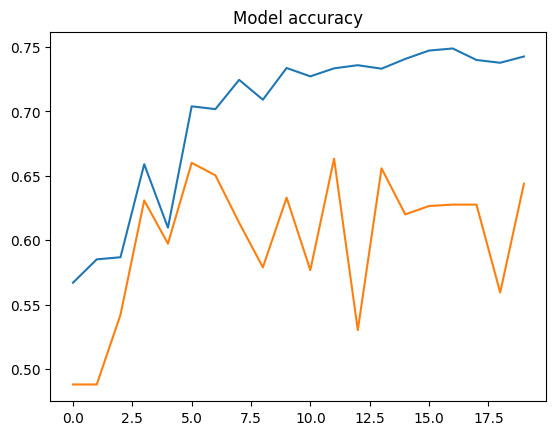

In [232]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
